__Background__:

I was inspired by one of Internet Historian video, [The Engoodening of No Man's Sky](https://www.youtube.com/watch?v=O5BJVO3PDeQ&t=1s), particularly this following segment:

"Then he starts breaking that (all the feedback of the game from various sources) down into datasets: people who haven't bought the game, people who have bought it and played it for a hundred hours, people who have returned it, etc. Then he starts compiling those complaints into usable data, focusing on the people with the most sincere experience of the game. Then he starts making a big list of all the things that need adding and prioritize them."

This workflow was really interesting to me, because it is applicable in many cases, especially in industry. So here it is, my first attempt on exploring the field of NLP. 

__Goals__:

Here, I am going to analyze the reviews on Steam games, a platform I mostly use to play video games. The exact goals of this project are:
- Analyze what words are associated with good reviews (reviewer recommended the game)
- Predicting whether a reviewer recommended the game or not based on the review

Obviously, this project is not going to be as grandeur as what Sean Murray did, but I would like to have a hands-on experience on sentiment analysis in general.

So please, enjoy!

In [1]:
# Import standard libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# import matplotlib as mpl
# mpl.rcParams['figure.dpi'] = 300

# COLOR = 'black'
# mpl.rcParams['text.color'] = 'black'
# mpl.rcParams['axes.labelcolor'] = COLOR
# mpl.rcParams['xtick.color'] = COLOR
# mpl.rcParams['ytick.color'] = COLOR

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

# Load data
data = pd.read_csv("data_scraping/recent_reviews_2022.csv")

# Data info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175873 entries, 0 to 175872
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   author             175873 non-null  object
 1   review             175234 non-null  object
 2   timestamp_created  175873 non-null  int64 
 3   voted_up           175873 non-null  bool  
 4   votes_up           175873 non-null  int64 
 5   votes_funny        175873 non-null  int64 
 6   name               175873 non-null  object
dtypes: bool(1), int64(3), object(3)
memory usage: 8.2+ MB


In [3]:
# Check data content
data.head()

author  \
0  {'steamid': '76561198876197793', 'num_games_ow...   
1  {'steamid': '76561198007107695', 'num_games_ow...   
2  {'steamid': '76561198103334117', 'num_games_ow...   
3  {'steamid': '76561198124243445', 'num_games_ow...   
4  {'steamid': '76561198355294063', 'num_games_ow...   

                                              review  timestamp_created  \
0                                               YES!         1640995265   
1  If you like crafting survival games, Icarus is...         1640995288   
2  officially addicted, I love this game. I wish ...         1640995389   
3  Game should be $5, I could make a more grindab...         1640995448   
4  I feel like since this game had a terrible lau...         1640995470   

   voted_up  votes_up  votes_funny  \
0      True         0            0   
1      True         0            0   
2      True         0            0   
3     False         8            1   
4      True         1            0   

                                                name  
0  Microsoft Flight Simulator Game of the Year Ed...  
1                                             ICARUS  
2                                          New World  
3                                       Back 4 Blood  
4                                     Cyberpunk 2077

Columns:
- `author`: The information in dictionary regarding the author of the review:
    - `steamid`: the user's steam ID.
    - `num_games_owned`: number of games owned by the user.
    - `num_reviews`: number of reviews written by the user.
    - `playtime_forever`: lifetime playtime tracked in this game.
    - `playtime_last_two_weeks`: playtime tracked in the past two weeks for this game.
    - `playtime_at_review`: playtime when the review was written (in minutes).
    - `last_played`: time for when the user last played this game.
- `review`: The text of user review.
- `timestamp_created`: date the review was created (unix timestamp).
- `voted_up`: Whether the reviewer recommended the game or not (True: recommended, False: not recommended).
- `votes_up`: How many other users think the review is helpful.
- `votes_funny`: How many other player think the review is funny.
- `name`: The game title being reviewed.

# 1. Preprocessing/Data Preparation

First, we will prepare the data so that it is easier to analyze. We will extract `steamid`, `num_games_owned`, `num_reviews`, and `playtime_at_review` from column `author` because it seems like an interesting feature to add.

In [4]:
# Extract playtime_at_review
import json

data['steam_id'] = data['author'].apply(lambda x: json.loads(x.replace("'",'"'))['steamid'])
data['num_games_owned'] = data['author'].apply(lambda x: json.loads(x.replace("'",'"'))['num_games_owned'])
data['num_reviews'] = data['author'].apply(lambda x: json.loads(x.replace("'",'"'))['num_reviews'])
data['hour_played'] = data['author'].apply(lambda x: round(json.loads(x.replace("'",'"'))['playtime_at_review']/60))

data.head()

author  \
0  {'steamid': '76561198876197793', 'num_games_ow...   
1  {'steamid': '76561198007107695', 'num_games_ow...   
2  {'steamid': '76561198103334117', 'num_games_ow...   
3  {'steamid': '76561198124243445', 'num_games_ow...   
4  {'steamid': '76561198355294063', 'num_games_ow...   

                                              review  timestamp_created  \
0                                               YES!         1640995265   
1  If you like crafting survival games, Icarus is...         1640995288   
2  officially addicted, I love this game. I wish ...         1640995389   
3  Game should be $5, I could make a more grindab...         1640995448   
4  I feel like since this game had a terrible lau...         1640995470   

   voted_up  votes_up  votes_funny  \
0      True         0            0   
1      True         0            0   
2      True         0            0   
3     False         8            1   
4      True         1            0   

                                                name           steam_id  \
0  Microsoft Flight Simulator Game of the Year Ed...  76561198876197793   
1                                             ICARUS  76561198007107695   
2                                          New World  76561198103334117   
3                                       Back 4 Blood  76561198124243445   
4                                     Cyberpunk 2077  76561198355294063   

   num_games_owned  num_reviews  hour_played  
0               28           10           25  
1             1290            1           57  
2              220            2          253  
3               55            9           11  
4              101           22           14

Next, we will convert the timestamps into date time format.

In [5]:
from datetime import datetime

data['date_posted'] = pd.to_datetime(data['timestamp_created'].apply(lambda x: datetime.fromtimestamp(x).strftime('%Y-%m-%d')))

data.head()

author  \
0  {'steamid': '76561198876197793', 'num_games_ow...   
1  {'steamid': '76561198007107695', 'num_games_ow...   
2  {'steamid': '76561198103334117', 'num_games_ow...   
3  {'steamid': '76561198124243445', 'num_games_ow...   
4  {'steamid': '76561198355294063', 'num_games_ow...   

                                              review  timestamp_created  \
0                                               YES!         1640995265   
1  If you like crafting survival games, Icarus is...         1640995288   
2  officially addicted, I love this game. I wish ...         1640995389   
3  Game should be $5, I could make a more grindab...         1640995448   
4  I feel like since this game had a terrible lau...         1640995470   

   voted_up  votes_up  votes_funny  \
0      True         0            0   
1      True         0            0   
2      True         0            0   
3     False         8            1   
4      True         1            0   

                                                name           steam_id  \
0  Microsoft Flight Simulator Game of the Year Ed...  76561198876197793   
1                                             ICARUS  76561198007107695   
2                                          New World  76561198103334117   
3                                       Back 4 Blood  76561198124243445   
4                                     Cyberpunk 2077  76561198355294063   

   num_games_owned  num_reviews  hour_played date_posted  
0               28           10           25  2022-01-01  
1             1290            1           57  2022-01-01  
2              220            2          253  2022-01-01  
3               55            9           11  2022-01-01  
4              101           22           14  2022-01-01

Finally, we will convert the recommendation (`voted_up`) into strings for readability: 'Recommended' for True and 'Not Recommended' for False. We will also convert it to integers: 1 if recommended, 0 if not for further processing.

In [6]:
data['recommendation'] = data['voted_up'].map({True:'Recommended', False:'Not Recommended'})
data['recommendation_int'] = data['voted_up'].astype(int)

data.head()

author  \
0  {'steamid': '76561198876197793', 'num_games_ow...   
1  {'steamid': '76561198007107695', 'num_games_ow...   
2  {'steamid': '76561198103334117', 'num_games_ow...   
3  {'steamid': '76561198124243445', 'num_games_ow...   
4  {'steamid': '76561198355294063', 'num_games_ow...   

                                              review  timestamp_created  \
0                                               YES!         1640995265   
1  If you like crafting survival games, Icarus is...         1640995288   
2  officially addicted, I love this game. I wish ...         1640995389   
3  Game should be $5, I could make a more grindab...         1640995448   
4  I feel like since this game had a terrible lau...         1640995470   

   voted_up  votes_up  votes_funny  \
0      True         0            0   
1      True         0            0   
2      True         0            0   
3     False         8            1   
4      True         1            0   

                                                name           steam_id  \
0  Microsoft Flight Simulator Game of the Year Ed...  76561198876197793   
1                                             ICARUS  76561198007107695   
2                                          New World  76561198103334117   
3                                       Back 4 Blood  76561198124243445   
4                                     Cyberpunk 2077  76561198355294063   

   num_games_owned  num_reviews  hour_played date_posted   recommendation  \
0               28           10           25  2022-01-01      Recommended   
1             1290            1           57  2022-01-01      Recommended   
2              220            2          253  2022-01-01      Recommended   
3               55            9           11  2022-01-01  Not Recommended   
4              101           22           14  2022-01-01      Recommended   

   recommendation_int  
0                   1  
1                   1  
2                   1  
3                   0  
4                   1

We have grabbed all of the relevant columns. Now I will rearrange the columns (and pick only the important ones) just for the sake of aesthetics.

In [7]:
data = data.copy()[['name', 'steam_id', 'review', 'date_posted', 'hour_played', 'votes_up', 'votes_funny', 'num_games_owned', 'num_reviews', 'recommendation', 'recommendation_int']]
data = data.rename(columns={'name': 'title'})

data.head()

title           steam_id  \
0  Microsoft Flight Simulator Game of the Year Ed...  76561198876197793   
1                                             ICARUS  76561198007107695   
2                                          New World  76561198103334117   
3                                       Back 4 Blood  76561198124243445   
4                                     Cyberpunk 2077  76561198355294063   

                                              review date_posted  hour_played  \
0                                               YES!  2022-01-01           25   
1  If you like crafting survival games, Icarus is...  2022-01-01           57   
2  officially addicted, I love this game. I wish ...  2022-01-01          253   
3  Game should be $5, I could make a more grindab...  2022-01-01           11   
4  I feel like since this game had a terrible lau...  2022-01-01           14   

   votes_up  votes_funny  num_games_owned  num_reviews   recommendation  \
0         0            0               28           10      Recommended   
1         0            0             1290            1      Recommended   
2         0            0              220            2      Recommended   
3         8            1               55            9  Not Recommended   
4         1            0              101           22      Recommended   

   recommendation_int  
0                   1  
1                   1  
2                   1  
3                   0  
4                   1

From the data info above, we can already notice that there are missing values in `review`. Since our work is going to be heavily relying on this column, we have to clean it from these missing values. In addition, we also need to check for duplicated values following the standard data cleaning procedure.

In [8]:
data[data['review'].isna()]

title           steam_id review  \
76                                   ICARUS  76561198399851946    NaN   
362     Fallout 3: Game of the Year Edition  76561198024881320    NaN   
399                                     UNO  76561198840867200    NaN   
840     Tom Clancy's Ghost Recon® Wildlands  76561197993860234    NaN   
923                       Battlefield™ 2042  76561198134195214    NaN   
...                                     ...                ...    ...   
173360                               ICARUS  76561198235410252    NaN   
173554  Tom Clancy's Ghost Recon® Wildlands  76561199003431730    NaN   
174243                      Resident Evil 3  76561198374042923    NaN   
174781                         No Man's Sky  76561198234688784    NaN   
175738                      Elite Dangerous  76561199192905211    NaN   

       date_posted  hour_played  votes_up  votes_funny  num_games_owned  \
76      2022-01-01           78         0            0               34   
362     2022-01-01           95         0            0              294   
399     2022-01-01           17         0            0               19   
840     2022-01-02           14         0            0               45   
923     2022-01-02           12         0            0               22   
...            ...          ...       ...          ...              ...   
173360  2022-09-15           25         0            0              134   
173554  2022-09-16           13         0            0               13   
174243  2022-09-17            3         0            0               15   
174781  2022-09-19           99         0            0               44   
175738  2022-09-21           39         0            0               24   

        num_reviews recommendation  recommendation_int  
76                3    Recommended                   1  
362             208    Recommended                   1  
399               6    Recommended                   1  
840               5    Recommended                   1  
923               8    Recommended                   1  
...             ...            ...                 ...  
173360            6    Recommended                   1  
173554            8    Recommended                   1  
174243            4    Recommended                   1  
174781            9    Recommended                   1  
175738            2    Recommended                   1  

[639 rows x 11 columns]

In [9]:
data.isna().sum()

title                   0
steam_id                0
review                639
date_posted             0
hour_played             0
votes_up                0
votes_funny             0
num_games_owned         0
num_reviews             0
recommendation          0
recommendation_int      0
dtype: int64

There are 639 rows with missing reviews, and that is nothing compared to the whole dataset. However, let's also explore this a bit. What games are mostly missing reviews?

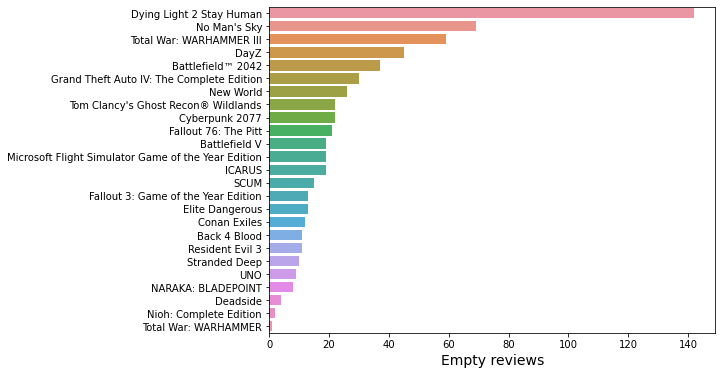

In [10]:
# Get rows with missing reviews
data_nan = data[data['review'].isna()]

# Make a bar plot
plt.figure(figsize=(8, 6))
missing_title = data_nan['title'].value_counts()
sns.barplot(x=missing_title.values,y=missing_title.index)
plt.xlabel('Empty reviews',fontsize=14)

plt.show()

In [11]:
# Drop rows with missing reviews
data.dropna(inplace=True)

# Sanity check
data.isna().sum()

title                 0
steam_id              0
review                0
date_posted           0
hour_played           0
votes_up              0
votes_funny           0
num_games_owned       0
num_reviews           0
recommendation        0
recommendation_int    0
dtype: int64

Next, let's check whether our dataset contains duplicated rows.

In [12]:
data.duplicated().sum()

0

We see that some reviews have doubles, which are probably errors during the data scraping part. Fortunately, we only lose about 3.3k rows of reviews, and ~21k remaining reviews to be analyed further which is still quite plenty. So we will drop the double rows.

In [13]:
data.drop_duplicates(keep='first', inplace=True)

# Sanity check
data.duplicated().sum()

0

# 2. EDA

### a) Categorical and date columns

First, let's check how many games are recommended vs not recommended.

recommendation
Recommended           72.055651
Not Recommended       27.944349

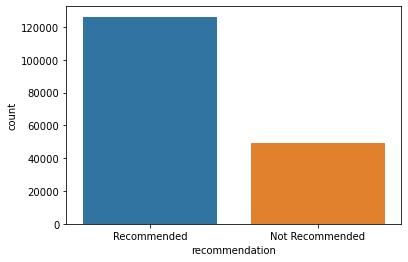

In [14]:
# Count plot of recommendation
sns.countplot(x='recommendation',data=data)

# Count in percentage
pd.DataFrame(data['recommendation'].value_counts(normalize=True)*100)

We see that this dataset is biased towards positive reviews (72%), which is expected since most of the games in this list have overall ratings of around 70%.

Let's check the top 10 games by playtime.

Text(0, 0.5, 'Title')

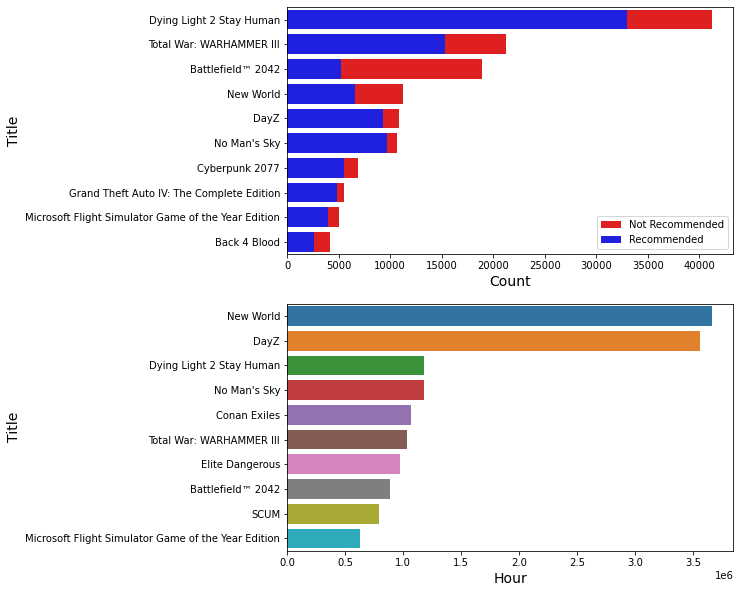

In [143]:
# Make figure and axes objects
fig, ax = plt.subplots(nrows=2,ncols=1,figsize=(8,10))

# All reviews
all_ = data[data['title'].isin(top_10_games_list)].groupby(by='title').size()
# Positive reviews
pos_ = data[(data['title'].isin(top_10_games_list)) & (data['recommendation_int']==1)].groupby(by='title').size()
# Combine the count of all reviews and positive reviews in a single dataframe
both_ = pd.DataFrame([all_, pos_], index=['neg', 'pos']).T.sort_values(by='neg', ascending=False)
# Plot the positive reviews on top of all reviews
sns.barplot(y=both_.index, x=both_['neg'], ax=ax[0], color='red', label='Not Recommended')
sns.barplot(y=both_.index, x=both_['pos'], ax=ax[0], color='blue', label='Recommended')
ax[0].set_xlabel('Count', fontsize=14)
ax[0].set_ylabel('Title',fontsize=14)
ax[0].legend()

# Barplot for most played games
top10_game_hour = data.groupby('title').agg(hour=('hour_played','sum')).sort_values(by='hour',ascending=False).head(10)
sns.barplot(y=top10_game_hour.index,x=top10_game_hour.hour,ax=ax[1])
ax[1].set_xlabel('Hour',fontsize=14)
ax[1].set_ylabel('Title',fontsize=14)

Among the most reviewed games in 2022, Dying Light 2, WARHAMMER III, and Battlefield 2042 are the most reviewed, which makes sense since they were released recently. We can also see that in terms of the ratio between the positive reviews to the total reviews, Battlefield 2042 seems to be the worst and No Man's Sky seems to be the best.

Let's check how many reviews are posted each day.

Text(0, 0.5, 'Review count')

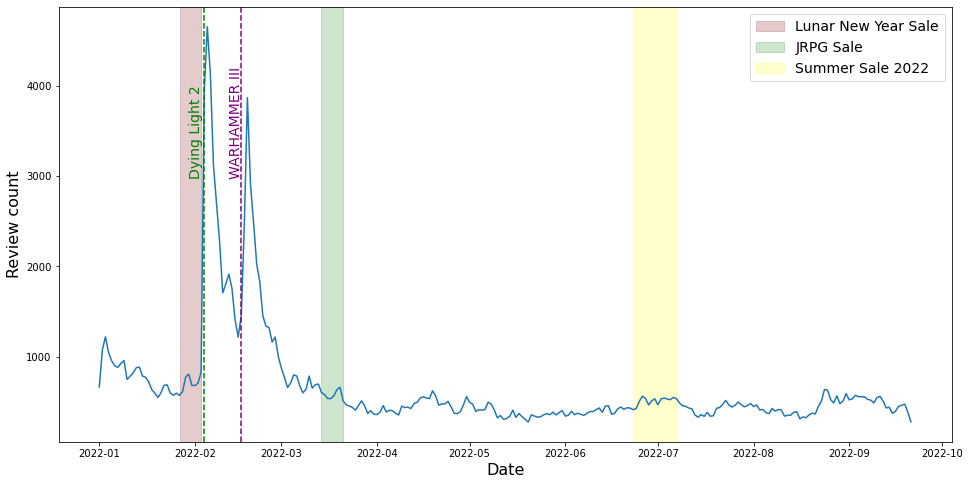

In [144]:
# Count reviews based on date posted
review_date = data.groupby(by='date_posted').agg(count=('date_posted','count'))
date = review_date.index
count = review_date.values

# Steam events (event name, starting date, ending date, color for the plot)
steam_events = [("Lunar New Year Sale", "2022-01-27", "2022-02-03", "maroon"),
                ("JRPG Sale", "2022-03-14", "2022-03-21", "green"),
                ("Summer Sale 2022", "2022-06-23", "2022-07-07", "yellow")]

# Release dates (game name, release date, color for the plot, x offset, y position)
release_dates = [("Dying Light 2", "2022-02-04", "green", 5, 3000),
                 ("WARHAMMER III", "2022-02-16", "purple", 4, 3000)]

# Create figure
plt.figure(figsize=(16,8))

# Plot total review each day
plt.plot(date,count)

# Plot Steam events
for event in steam_events:
    plt.axvspan(np.datetime64(event[1]), np.datetime64(event[2]), alpha=0.2, color=event[3], label=event[0])

# Plot release dates and the corresponding game name
for release_date in release_dates:
    plt.axvline(x=np.datetime64(release_date[1]),ls='--',color=release_date[2])
    plt.text(np.datetime64(release_date[1])-release_date[3],release_date[4],release_date[0],fontsize=14,rotation='vertical',color=release_date[2])

# Legend, axis labels, ticks
plt.legend(fontsize=14)
plt.xlabel('Date',fontsize=16)
plt.ylabel('Review count',fontsize=16)

It seems like the two most prominent spikes correlate with the release of the two best-selling games of 2022 so far.

Now, let's see the reviews for each of these top 6 games by date, the official release dates, and the Steam sales.

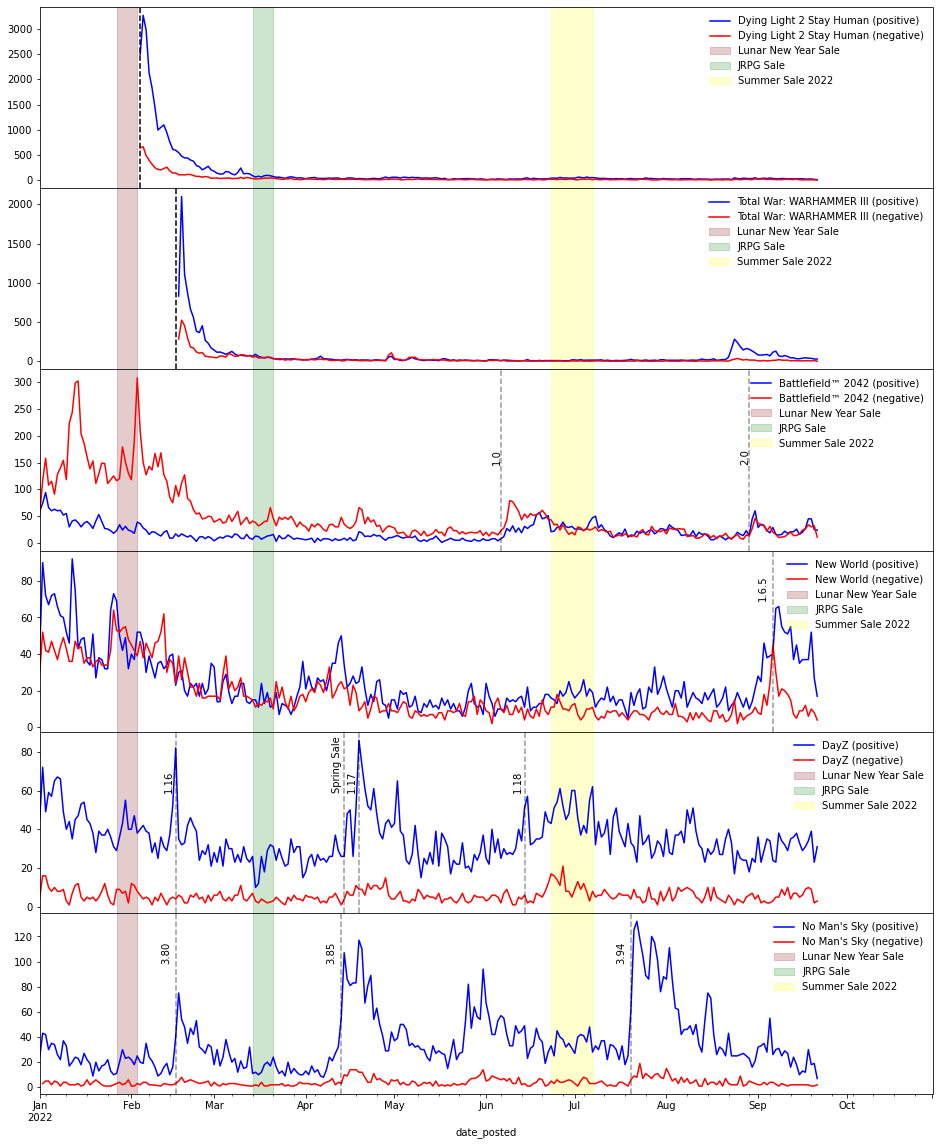

In [66]:
# Top 6 game (sorted by early release date)
top6_game = data['title'].value_counts().head(6).index

# Create figure and axis objects
fig, (ax1,ax2,ax3,ax4,ax5,ax6) = plt.subplots(nrows=6,ncols=1,sharex=True,figsize=(16,20))

# Color for the plot
color_list = ['blue','purple','green','red','orange','violet']

# Plot review count
# See just the total review count or divide the positive and negative review counts
divide_classes = True
for i, ax in enumerate(fig.axes):
    if not divide_classes:
        data[data['title']==top6_game[i]].groupby('date_posted')['review'].count().plot(ax=ax,label=top6_game[i],color=color_list[i])
    else:
        data[(data['title']==top6_game[i]) & (data['recommendation_int']==1)].groupby('date_posted')['review'].count().plot(ax=ax,label=top6_game[i]+' (positive)',color='blue')
        data[(data['title']==top6_game[i]) & (data['recommendation_int']==0)].groupby('date_posted')['review'].count().plot(ax=ax,label=top6_game[i]+' (negative)',color='red')
    
    # Plot Steam events
    for event in steam_events:
        ax.axvspan(np.datetime64(event[1]), np.datetime64(event[2]), alpha=0.2, color=event[3], label=event[0])
    ax.legend(loc='upper right',fontsize=10,frameon=False)

# Plot game release date
for (i, release_date) in enumerate(release_dates):
    ax = fig.axes[i]
    ax.axvline(x=np.datetime64(release_date[1]),ls='--',color='k')

# Update patch for some of the games (update name, date)
# Battlefield
update_bf = [("1.0", "2022-06-06"),
             ("2.0", "2022-08-29")]
for update in update_bf:
    ax = fig.axes[2]
    ax.axvline(x=np.datetime64(update[1]), ls='--', alpha=0.4, color='k')
    ax.text(np.datetime64(update[1])-3, 150, update[0],fontsize=10,rotation='vertical',color='k')

# New World
update_nw = [("1.6.5", "2022-09-06")]
for update in update_nw:
    ax = fig.axes[3]
    ax.axvline(x=np.datetime64(update[1]), ls='--', alpha=0.4, color='k')
    ax.text(np.datetime64(update[1])-5, 70, update[0],fontsize=10,rotation='vertical',color='k')

# DayZ
update_dayz = [("1.16", "2022-02-16"),
               ("Spring Sale", "2022-04-14"), 
               ("1.17", "2022-04-19"),
               ("1.18", "2022-06-14")]
for update in update_dayz:
    ax = fig.axes[4]
    ax.axvline(x=np.datetime64(update[1]), ls='--', alpha=0.4, color='k')
    ax.text(np.datetime64(update[1])-4, 60, update[0],fontsize=10,rotation='vertical',color='k')

# No Man's Sky
update_nms = [("3.80", "2022-02-16"),
              ("3.85", "2022-04-13"),
              ("3.94", "2022-07-20")]
for update in update_nms:
    ax = fig.axes[5]
    ax.axvline(x=np.datetime64(update[1]), ls='--', alpha=0.4, color='k')
    ax.text(np.datetime64(update[1])-5, 100, update[0],fontsize=10,rotation='vertical',color='k')

plt.xlim(right=np.datetime64("2022-10-30"))
plt.subplots_adjust(hspace=0)

### b) Numerical columns

Let's create a column containing the length of the review. This is a common step in text analysis, since the length of a text may correlate with the target variable.

In [67]:
# Length of characters in the review
data['length'] = data['review'].apply(len)

data.head()

Let's check the summary statistics for the numerical columns, i.e. `funny`, `helpful`, `hour_played`, and `length`.

In [86]:
# summary statistics
num_cols = ['num_games_owned', 'num_reviews', 'votes_funny', 'votes_up', 'hour_played', 'length']
data[num_cols].describe()

num_games_owned    num_reviews    votes_funny       votes_up  \
count    175234.000000  175234.000000  175234.000000  175234.000000   
mean        136.937529      11.752708       0.693387       3.095119   
std         235.516449      32.184589      27.445861      62.612750   
min           0.000000       1.000000       0.000000       0.000000   
25%          29.000000       2.000000       0.000000       0.000000   
50%          71.000000       5.000000       0.000000       0.000000   
75%         162.000000      12.000000       0.000000       1.000000   
max       19866.000000    7851.000000    8791.000000   12258.000000   

         hour_played         length  
count  175234.000000  175234.000000  
mean      101.536431     262.593133  
std       313.939792     606.295354  
min         0.000000       1.000000  
25%        10.000000      18.000000  
50%        28.000000      69.000000  
75%        70.000000     239.000000  
max     16846.000000    8000.000000

We can see that most of the funny and helpful ratings are 0 or empty, up to the 75th percentile, which makes sense since most reviews should go unnoticed by the community. 

Looking at the maximum values, some of them are surprisingly high. One of the author owns 19866 games, and the most played game among the review has 16846 hours worth of playtime. Let's check the records that contain the maximum values of each feature.

In [85]:
# Most numbers of owned games
display(data[data['num_games_owned']==max(data['num_games_owned'])])

# Author with the most reviews
display(data[data['num_reviews']==max(data['num_reviews'])])

# Funniest review
display(data[data['votes_funny']==max(data['votes_funny'])])
print(data[data['votes_funny']==max(data['votes_funny'])]['review'].values[0], '\n')

# Most helpful review
display(data[data['votes_funny']==max(data['votes_funny'])])
print(data[data['votes_up']==max(data['votes_up'])]['review'].values[0], '\n')

# Highest playtime
display(data[data['hour_played']==max(data['hour_played'])])

# Longest review
display(data[data['length']==max(data['length'])])
print(data[data['length']==max(data['length'])]['review'].values[0], '\n')

title           steam_id  \
44539  Dying Light 2 Stay Human  76561197995008105   

                                                  review date_posted  \
44539  There were better names for this game:\n\n1.) ...  2022-02-08   

       hour_played  votes_up  votes_funny  num_games_owned  num_reviews  \
44539            0         7            3            19866           23   

        recommendation  recommendation_int  length  
44539  Not Recommended                   0    1496

title           steam_id  \
129932  New World  76561198030784015   

                                                   review date_posted  \
129932  New World is a high budget MMORPG with a uniqu...  2022-06-12   

        hour_played  votes_up  votes_funny  num_games_owned  num_reviews  \
129932            8         1            5             6747         7851   

       recommendation  recommendation_int  length  
129932    Recommended                   1    1219

title           steam_id                 review  \
10060  Battlefield™ 2042  76561198053108226  I'd rather buy WinRAR   

      date_posted  hour_played  votes_up  votes_funny  num_games_owned  \
10060  2022-01-11           10     12258         8791              511   

       num_reviews   recommendation  recommendation_int  length  
10060            1  Not Recommended                   0      21

I'd rather buy WinRAR 



title           steam_id                 review  \
10060  Battlefield™ 2042  76561198053108226  I'd rather buy WinRAR   

      date_posted  hour_played  votes_up  votes_funny  num_games_owned  \
10060  2022-01-11           10     12258         8791              511   

       num_reviews   recommendation  recommendation_int  length  
10060            1  Not Recommended                   0      21

I'd rather buy WinRAR 



title           steam_id  \
9685  Conan Exiles  76561198805704437   

                                                 review date_posted  \
9685  As shown by time played I really enjoy this ga...  2022-01-11   

      hour_played  votes_up  votes_funny  num_games_owned  num_reviews  \
9685        16846         0            0               29            1   

     recommendation  recommendation_int  length  
9685    Recommended                   1     131

title           steam_id  \
5945                                   SCUM  76561198079962989   
9877                 Nioh: Complete Edition  76561197981638563   
16697                         Stranded Deep  76561198325747868   
25173                     Battlefield™ 2042  76561198411835767   
40890              Dying Light 2 Stay Human  76561198160904270   
41152              Dying Light 2 Stay Human  76561198159385322   
41361              Dying Light 2 Stay Human  76561198060758555   
51458              Dying Light 2 Stay Human  76561197996972442   
52779              Dying Light 2 Stay Human  76561198063656273   
67327              Total War: WARHAMMER III  76561198101253848   
79136                  Fallout 76: The Pitt  76561197981638563   
102522             Dying Light 2 Stay Human  76561198077948736   
126271                                  UNO  76561198094306650   
126730                         No Man's Sky  76561198819382293   
171083  Tom Clancy's Ghost Recon® Wildlands  76561198294610454   

                                                   review date_posted  \
5945    [h1] Introduction [/h1]\nI cannot recommend th...  2022-01-07   
9877    [h1]“YOU AND YOUR FRIENDS ARE DEAD.\nGAME OVER...  2022-01-11   
16697   WORSHIP THE CRAB ALL HAIL THE CRAB WORSHIP THE...  2022-01-20   
25173   Refund Refund Refund Refund Refund Refund Refu...  2022-02-02   
40890   TLDR -I ran my word count down oops\nNON SPOIL...  2022-02-07   
41152   Zombie go brrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrr...  2022-02-07   
41361   If you're buying this game for story, expectin...  2022-02-07   
51458   I played this game on KB+M and this review wil...  2022-02-12   
52779   I LOVED dying light 1.. played through every c...  2022-02-13   
67327   POSTED: 18 FEBRUARY\nRemove denuvo, so that pl...  2022-02-19   
79136   [h1]“Almost heaven, West Virginia~”\n~[i]John ...  2022-02-26   
102522  Dying light 2 is one of the most complicated r...  2022-04-07   
126271  I HATE UNO I HATE UNO I HATE UNO I HATE UNO I ...  2022-06-03   
126730   Space  Space  Space  Space  Space  Space  Spa...  2022-06-04   
171083  The unanimous Declaration of the thirteen unit...  2022-09-10   

        hour_played  votes_up  votes_funny  num_games_owned  num_reviews  \
5945             58        90           10              198           25   
9877             20         7            0             3847          495   
16697           192        69          101               50            2   
25173           110         3            1               38            6   
40890            33         0            0              705          116   
41152             8         0            0               70            4   
41361            35         2            0              137            6   
51458            53         0            0              690           54   
52779            13         0            1              133            8   
67327            10         7            0             1204           35   
79136            33        10            0             3847          495   
102522           47         0            1              358           20   
126271            3         3            4              265           10   
126730          204         0            0               64            8   
171083            2         0            1               44            8   

         recommendation  recommendation_int  length  
5945    Not Recommended                   0    8000  
9877        Recommended                   1    8000  
16697       Recommended                   1    8000  
25173   Not Recommended                   0    8000  
40890       Recommended                   1    8000  
41152       Recommended                   1    8000  
41361   Not Recommended                   0    8000  
51458   Not Recommended                   0    8000  
52779   Not Recommended                   0    8000  
67327       Recommended                   1    8000  
7

[h1] Introduction [/h1]
I cannot recommend this game for everyone. But I will recommend it for some.
I'll try and explain this briefly
So here's the thing, if you aren't into survival games, you probably wouldn't even be reading this review, but if you aren't familiar with survival games, you should probably go look into other games than this one not to scare you off, I recommend something easy to get to know like Rust. 
Now, to explain this to everyone else who don't know what the game is about, basically it's survival games taken to the "extreme" to be short. You have an excessive amount of options for maintaining your body and health. This includes vitamins, extensive cold/heat system and an very well done but also advanced weight system. I'll explain everything further in this review if this sounds interesting to you or if you're just bored. 
So lets start off with the positive(these could also be seen as negatives, depending on how much you're into survival games)

[h1] Pros [/h1]

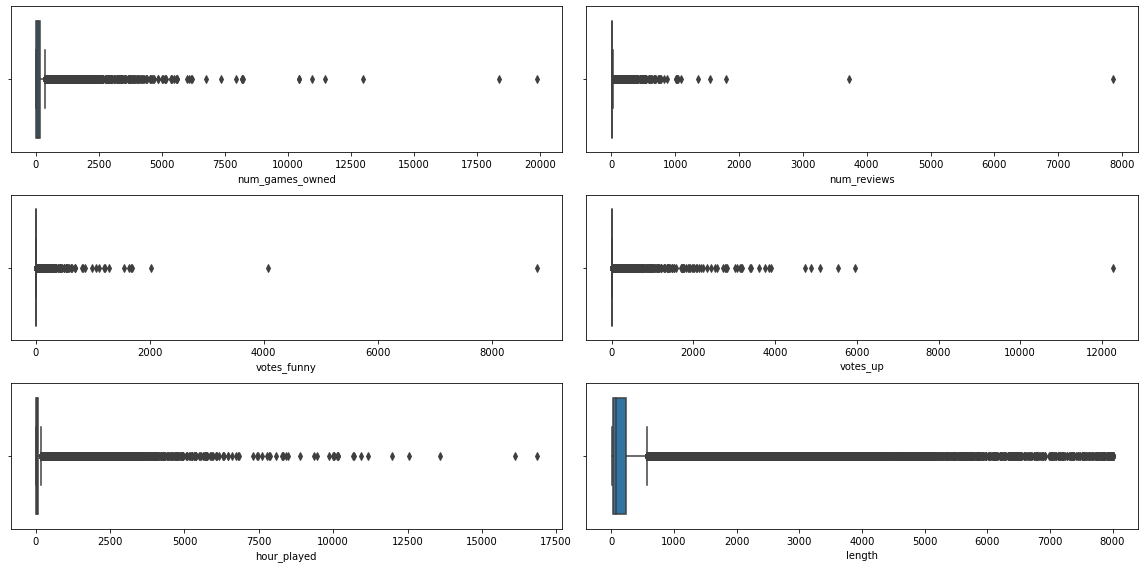

In [89]:
# Check the distribution for these numerical columns
# Create boxplot
plt.figure(figsize=(16,8))
for i, col in enumerate(num_cols):
    plt.subplot(3,2,i+1)
    sns.boxplot(x=col,data=data)
    plt.tight_layout()

Just to make the visualization easier, we will transform them to log units (using log1p function to avoid log(0))

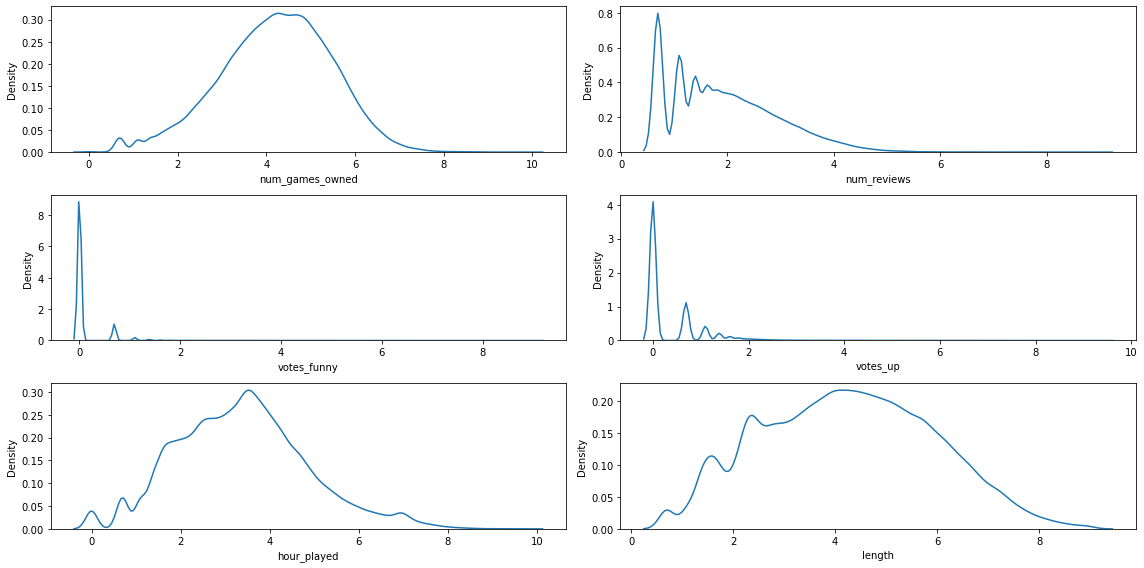

In [159]:
# Take log of numerical columns
data_num_log = np.log1p(data[num_cols])

# Plot review length distribution
plt.figure(figsize=(16,8))
for i, col in enumerate(num_cols):
    plt.subplot(3,2,i+1)
    sns.kdeplot(x=col,data=data_num_log)
    plt.tight_layout()

Let's check if there are any correlation between each pair of the numerical features.

In [163]:
data

title           steam_id  \
0       Microsoft Flight Simulator Game of the Year Ed...  76561198876197793   
1                                                  ICARUS  76561198007107695   
2                                               New World  76561198103334117   
3                                            Back 4 Blood  76561198124243445   
4                                          Cyberpunk 2077  76561198355294063   
...                                                   ...                ...   
175868                           Dying Light 2 Stay Human  76561198305533198   
175869                               Fallout 76: The Pitt  76561198169762994   
175870          Grand Theft Auto IV: The Complete Edition  76561199173421209   
175871                                    Elite Dangerous  76561198035393387   
175872          Grand Theft Auto IV: The Complete Edition  76561199123643713   

                                                   review date_posted  \
0                                                    YES!  2022-01-01   
1       If you like crafting survival games, Icarus is...  2022-01-01   
2       officially addicted, I love this game. I wish ...  2022-01-01   
3       Game should be $5, I could make a more grindab...  2022-01-01   
4       I feel like since this game had a terrible lau...  2022-01-01   
...                                                   ...         ...   
175868  Really janky, boring story. Doesn't live up to...  2022-09-21   
175869                                          It's good  2022-09-21   
175870                                       i was awesom  2022-09-21   
175871  I first played this game on the BBC Micro back...  2022-09-21   
175872  Only good if you spend an hour patching and fi...  2022-09-21   

        hour_played  votes_up  votes_funny  num_games_owned  num_reviews  \
0                25         0            0               28           10   
1                57         0            0             1290            1   
2               253         0            0              220            2   
3                11         8            1               55            9   
4                14         1            0              101           22   
...             ...       ...          ...              ...          ...   
175868           27         0            0               47            7   
175869          154         0            0               49            1   
175870          116         0            0                9            1   
175871            2         0            0               58           21   
175872           64         0            0                7            6   

         recommendation  recommendation_int  length  
0           Recommended                   1       4  
1           Recommended                   1     156  
2           Recommended                   1     402  
3       Not Recommended                   0      64  
4           Recommended                   1     300  
...                 ...                 ...     ...  
175868  Not Recommended                   0      59  
175869      Recommended                   1       9  
175870      Recommended                   1      12  
175871      Recommended                   1     230  
175872      Recommended                   1      79  

[175234 rows x 12 columns]

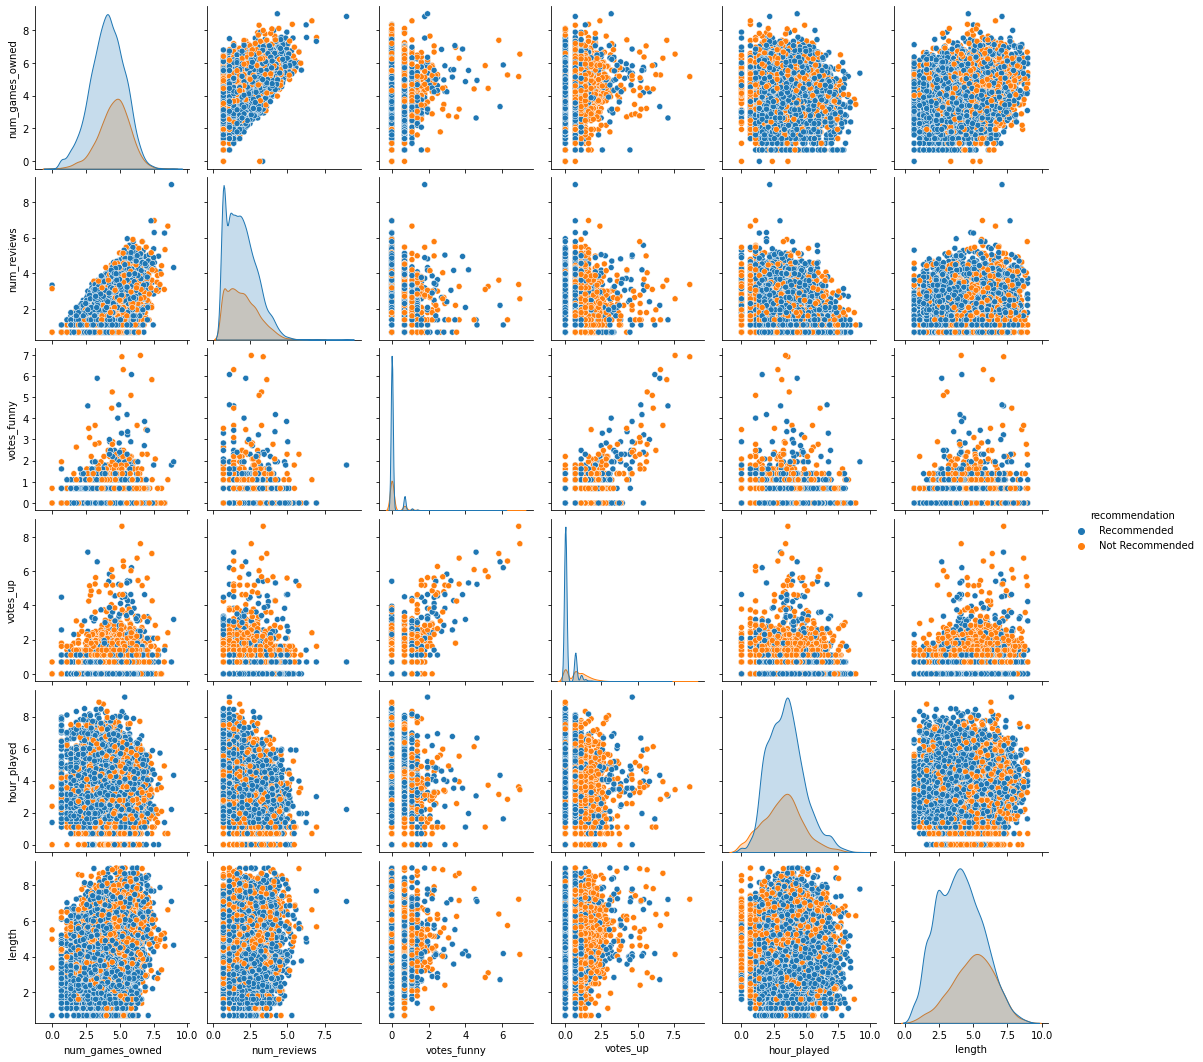

In [169]:
# Create pairplot for numerical columns
data_num_log = data_num_log.merge(data['recommendation'], left_index=True, right_index=True).sample(10000)
sns.pairplot(data_num_log, hue='recommendation')

There seems to be some correlation between the helpfulness (`votes_up`) and the funniness (`votes_funny`) of a review. Other than that, these features do not seem to correlate with each other, nor the histograms show any dependency with `recommendation`.

### c) Word Cloud

Let's make a word cloud for the entire dataset.

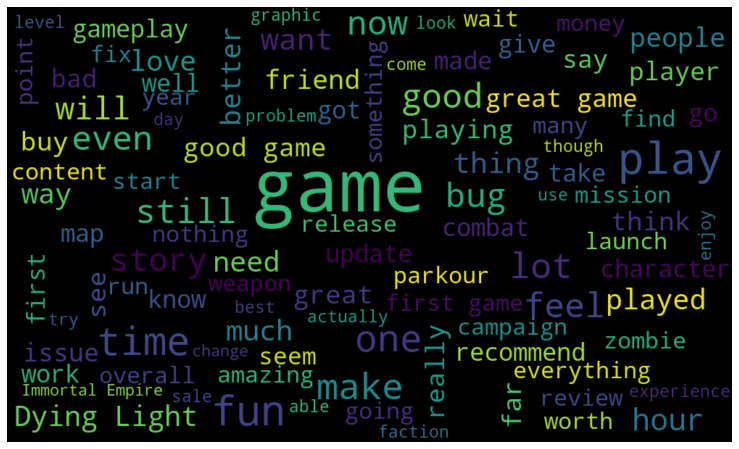

In [171]:
from wordcloud import WordCloud

def create_wordcloud(data,cm):
    txt = ' '.join(rev for rev in data['review'])
    plt.figure(figsize=(15,8))

    wordcloud = WordCloud(
                background_color = 'black',
                max_font_size = 100,
                max_words = 100,
                width = 1000,
                height = 600,
                colormap=cm
                ).generate(txt)


    plt.imshow(wordcloud,interpolation = 'bilinear')
    plt.axis('off')
    plt.show()
    return

create_wordcloud(data,'viridis')

Now, let's make a word cloud for the positive review (recommended games).

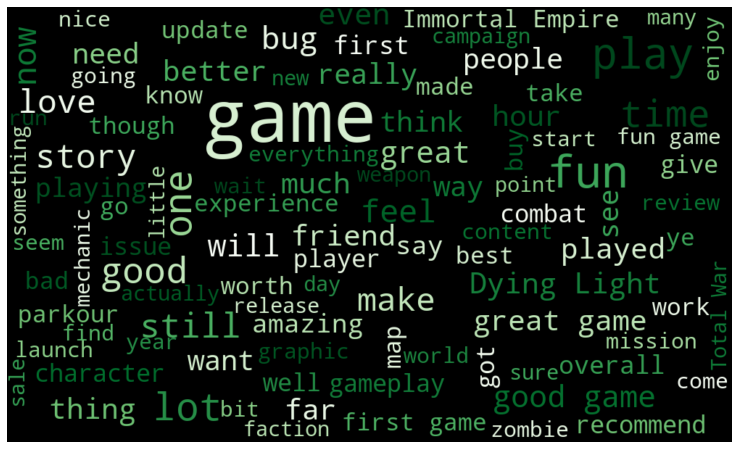

In [172]:
create_wordcloud(data[data['recommendation']=='Recommended'],'Greens')

We can see that the most common words are 'love', 'great', 'enjoy', 'fun' etc. They all convey positive emotions.

Finally, let's create a word cloud for the negative reviews (not recommended).

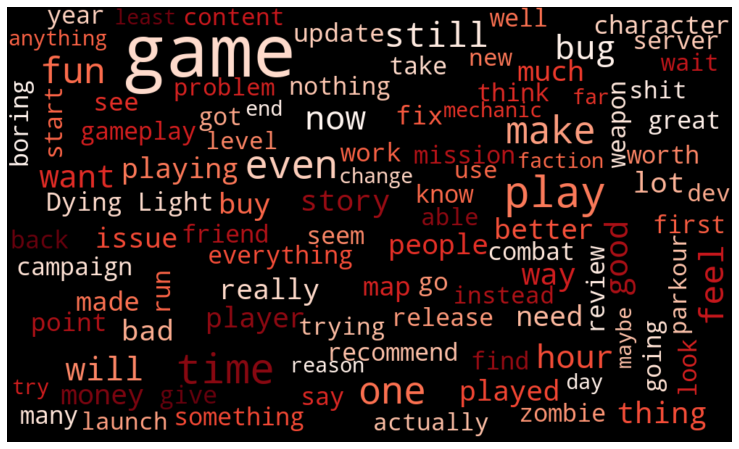

In [173]:
create_wordcloud(data[data['recommendation']=='Not Recommended'],'Reds')

We can see that the most common words are 'boring', 'bug', 'fix', and 'problem'. They all convey negative emotions.

# 3. Text Processing

This is where the real work begin. Basically, we want to convert these reviews into something that can be understood by the machine, i.e. numbers. However, we will not be using the entire dataset, because it will take too much time. I will only use reviews posted in the year 2019. For the most part, we will use regular expression and the `nltk` library to process the reviews.

First, we will remove any non alphanumeric characters from the document.

### a. Remove non-alphanumeric characters

In [ ]:
# Use regular expression
import re

# Define the function
def remove_symbols(text):
    text = re.sub(r"[^a-zA-Z0-9?!.,]+", ' ', text)
    return text

### b. Remove Punctuation and Digits and convert to lower case

Punctuations such as ',','.','?','!' and digits such as '1','2','3' are useless in text analysis, so we will remove them. We also convert each alphabetical character to lower case to reduce the number of words, since Python is case-sensitive.

In [ ]:
# Use string package to get list of punctuation
import string

# Create a function to remove punctuation
def remove_special_char(text):
    # Remove digits with regular expression
    text = re.sub(r'\d+', '', text)
    
    # Check characters to see if they are in punctuation and remove punctuation
    # Store lowercase character
    nopunc = [char.lower() for char in text if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    return nopunc

### c. Remove Stop Words

Stop words such as 'i', 'me', 'my', 'myself', 'we', 'our' appear very often and therefore useless for making predictions. We will use nltk's list of stop words to remove the stop words in our reviews.

In [ ]:
from nltk.corpus import stopwords

def remove_stopwords(text):
    # Split the review into words
    text = text.split()
    
    # Check word if it is in nltk's stop word list and remove them
    no_stopword = [word for word in text if word not in (stopwords.words('english'))]
    
    return ' '.join(no_stopword)

### d. Stemming

Words such as 'going', 'went', 'gone' and 'goes' stem from the same word, 'go'. This process of converting words into their base form is called stemming. In text analysis, we do stemming to reduce complexity. We will use Snowball Stemmer for this purpose.

In [ ]:
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize

def stemming(text):
    stem=[]
    
    snowball_stemmer = SnowballStemmer('english')
    
    word_tokens = word_tokenize(text)
    
    stemmed_word = [snowball_stemmer.stem(word) for word in word_tokens]
    
    stem=' '.join(stemmed_word)
    
    return stem

### e. Remove Irrelevant Words

In addition to the stop words provided in the nltk library, there are also words that appear frequently that convey no sentiment, such as 'game' and 'get'. These words are obtained from inspecting the wordcloud and they are removed iteratively from the document (all done manually!).

In [ ]:
def remove_irrelevant_words(text):
    
    irrelevant_words = ['game','get','gt','got','play']
    
    word_tokens = word_tokenize(text)
    
    cleaned_text = [word for word in word_tokens if word not in irrelevant_words]
    
    cleaned_text = ' '.join(cleaned_text)
    
    return cleaned_text

We have done the main steps in text processing. Now, let's apply these functions to our document.

In [ ]:
# Clean the reviews by combining the previous functions
def clean_text(data):
    data_clean = data.copy()
    data_clean['review'] = data_clean['review'].apply(remove_symbols)
    data_clean['review'] = data_clean['review'].apply(remove_special_char)
    data_clean['review'] = data_clean['review'].apply(remove_stopwords)
    data_clean['review'] = data_clean['review'].apply(stemming)
    data_clean['review'] = data_clean['review'].apply(remove_irrelevant_words)
    return data_clean

data_clean = clean_text(data)

In [ ]:
# Compare the original and cleaned review
print('Original review: \n', data['review'].loc[0] ,'\n')
print('Cleaned review: \n', data_clean['review'].loc[0])

Original review: 
 Pretty much same controls and buggy mess as all the other battle royale games. 

Cleaned review: 
 pretti much control buggi mess battl royal


### e. Word Cloud (Again)

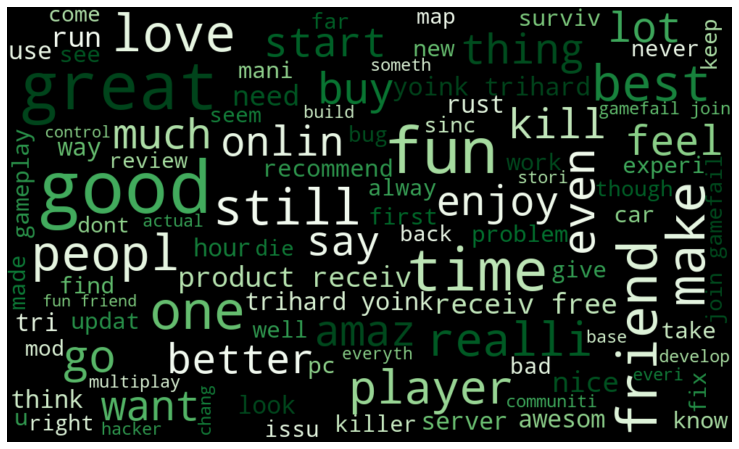

In [ ]:
# For positive reviews
create_wordcloud(data_clean[data_clean['recommendation']=='Recommended'],'Greens')

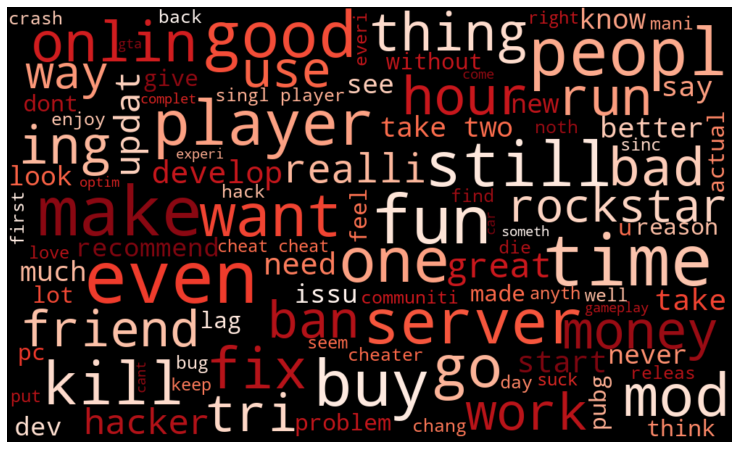

In [ ]:
# For negative reviews
create_wordcloud(data_clean[data_clean['recommendation']=='Not Recommended'],'Reds')

In [ ]:
from collections import Counter

# Check the most frequent word
review_vis2 = data_clean.copy()
review_vis2['temp_list'] = review_vis2['review'].apply(lambda x:str(x).split())
top = Counter([item for sublist in review_vis2['temp_list'] for item in sublist])
temp = pd.DataFrame(data=[top.keys(),top.values()]).T
temp.columns = ['Common_words','count']
temp.sort_values(by='count',ascending=False).head(10).reset_index(drop=True)

Common_words count
0          fun  4079
1         good  3897
2         like  3843
3         time  3145
4        great  2608
5          one  2400
6       player  2387
7         make  2299
8       friend  2279
9         even  2195

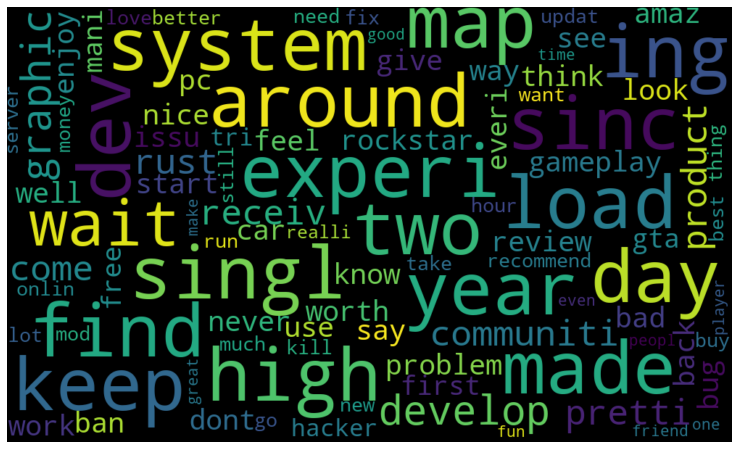

In [ ]:
# Word cloud for top words
create_wordcloud(temp.rename(columns={'Common_words':'review'}).sort_values(by='count').tail(100),'viridis')

Therefore 'fun', 'good', and 'like' are the most common words in our document, which is expected since most of the reviews are positive.

# 4. Baseline model: Simple Bag-of-Words/Count Vector

We have cleaned the reviews. Now, it's time to vectorize the reviews and create a model to predict whether a review conveys a positive or a negative sentiment.

In [ ]:
# Train-test split
from sklearn.model_selection import train_test_split

data_train, data_test = train_test_split(data_clean, test_size=0.3, random_state=42)

In [ ]:
# Import text vectorizers
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
# Import classifiers
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
# Import pipeline
from sklearn.pipeline import Pipeline
# ROC curve and PR curve
from sklearn.metrics import roc_curve, precision_recall_curve
# Import grid search, randomized search, and stratified folding
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold, cross_val_score
# Import hyperopt for Bayesian search
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe, space_eval

# For model evaluation
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, roc_auc_score,recall_score, precision_score

# Function to print evaluation metric
def model_evaluation(name,y_test,y_pred):
    round_result = 3
    print(f'Model: {name}','\n')
    cm = confusion_matrix(y_test,y_pred)
    print('Confusion matrix: \n', cm,'\n')
    print('Classification report: \n',classification_report(y_test,y_pred))
    print("\n")
    print(f'TN - True Positive: {cm[1,1]}')
    print(f'FP - False Negative: {cm[1,0]}')
    print(f'FN - False Positive: {cm[0,1]}')
    print(f'TP - True Negative: {cm[0,0]}')
    print(f'Accuracy Rate: {round(accuracy_score(y_test,y_pred),round_result)*100}%')
    print(f'Misclassification Rate: {round(1-accuracy_score(y_test,y_pred),round_result)*100}%')
    print(f'Recall: {round(recall_score(y_test,y_pred),round_result)}')
    print(f'Precision: {round(precision_score(y_test,y_pred),round_result)}')
    print(f'F1-Score: {round(f1_score(y_test,y_pred),round_result)}')
    print(f'ROC-AUC score: {round(roc_auc_score(y_test,y_pred),round_result)}')
    return

# Create a class for the machine learning model
class Model():
    
    def __init__(self,name,df,vectorizer,classifier,fixed_params={},random_state=42,test_size=0.3):
        self.name = name
        self.vectorizer = vectorizer
        self.classifier = classifier
        self.seed = random_state
        self.fixed_params = fixed_params
        self.fixed_params['random_state'] = random_state
        
        # split the data into train and test data by test_size:1-test_size
        self.feature = 'review'
        self.target = 'recommendation_int'
        self.X_train = df[self.feature]
        self.y_train = df[self.target]
        
        # Create a pipeline
        self.pipeline = Pipeline([
                            ('vec', self.vectorizer),
                            ('clf', self.classifier)
                            ])
    
    def train_and_evaluate_base(self,k_folds=10):
        
        # Split the training into training-validation (cross-validation)
        skf = StratifiedKFold(n_splits=k_folds)
        X = self.X_train
        y = self.y_train
        
        # Generate list to store score from CV method
        self.cv_accuracy_score = []
        self.cv_roc_auc_score = []
        
        # Iterate over the k-folds and save the scores
        for i, (train, valid) in enumerate(skf.split(X, y)):
            self.pipeline.fit(X.iloc[train], y.iloc[train])
            y_valid_pred = self.pipeline.predict(X.iloc[valid])
            self.cv_accuracy_score.append(accuracy_score(y.iloc[valid],y_valid_pred))
            self.cv_roc_auc_score.append(roc_auc_score(y.iloc[valid],y_valid_pred))
        
        # Print the mean value of the CV results
        print(f'Accuracy score: {round(np.mean(self.cv_accuracy_score)*100,3)}%')
        print(f'ROC AUC score: {round(np.mean(self.cv_roc_auc_score),3)}')
        
        return
    
    # Perform bayesian search over the hyperparameter space
    # Objective function whose loss we want to minimize
    def objective_func(self,args):
        # Initialize model pipeline
        pipe = self.pipeline
        
        # Model parameters will be set here
        pipe.set_params(**args) 

        # Cross Validation Score
        score = cross_val_score(pipe, self.X_train, self.y_train,scoring='accuracy', cv=5, n_jobs=-1, error_score=0.99)

        # We return 1- score to minimize it
        return {'loss': 1 - np.mean(score), 'status': STATUS_OK}
    
    # Get the best hyperparameters using Bayesian search
    def bayes_search(self,space,max_evals=50):
        
        # Hyperopts Trials() records all the model and run artifacts.
        trials = Trials()

        # Fmin will call the objective function with selective param set. 
        # The choice of algorithm will narrow the searchspace.
        self.best_classifier = fmin(self.objective_func, space, algo=tpe.suggest,
                               max_evals=max_evals, trials=trials,rstate=np.random.default_rng(self.seed))
        self.best_params_hp = space_eval(space, self.best_classifier)
        return
    
    # Model evaluation after performing hyperparameter tuning
    def train_and_evaluate_hp(self,k_folds=10):
        # Create a pipeline
        self.pipeline_hp = Pipeline([
                            ('vec', self.vectorizer),
                            ('clf', self.classifier)
                            ])
        # Use the best hyperparameters
        self.pipeline_hp.set_params(**self.best_params_hp)
        
        # Split the training into training-validation (cross-validation)
        skf = StratifiedKFold(n_splits=k_folds)
        X = self.X_train
        y = self.y_train
        
        # Generate list to store score from CV method
        self.cv_accuracy_score_hp = []
        self.cv_roc_auc_score_hp = []
        
        # Iterate over the k-folds and save the scores
        for i, (train, valid) in enumerate(skf.split(X, y)):
            self.pipeline_hp.fit(X.iloc[train], y.iloc[train])
            y_valid_pred = self.pipeline.predict(X.iloc[valid])
            self.cv_accuracy_score_hp.append(accuracy_score(y.iloc[valid],y_valid_pred))
            self.cv_roc_auc_score_hp.append(roc_auc_score(y.iloc[valid],y_valid_pred))
        
        # Print the mean value of the CV results
        print(f'Accuracy score: {round(np.mean(self.cv_accuracy_score_hp)*100,3)}%')
        print(f'ROC AUC score: {round(np.mean(self.cv_roc_auc_score_hp),3)}')
        
        return
    
    # Final model evaluation
    def predict_test(self,data_test,use_hyperparameter):
        
        # Get feature and target from test data
        self.X_test = data_test[self.feature]
        self.y_test = data_test[self.target]
        
        # Define a fresh pipeline
        self.final_pipeline = Pipeline([
                            ('vec', self.vectorizer),
                            ('clf', self.classifier)
                            ])
        
        # If hyperparameters are used, get them from bayesian search
        if use_hyperparameter:
            self.final_pipeline.set_params(**self.best_params_hp)
        
        # Fit model with training data
        self.final_pipeline.fit(self.X_train,self.y_train)
        
        # Make predictions for test set
        self.y_pred_proba = self.final_pipeline.predict_proba(self.X_test)
        y_pred = self.final_pipeline.predict(self.X_test)
        
        # Print model evaluation
        model_evaluation(self.name,self.y_test,y_pred)
        return
    
    # Plot ROC curve
    def get_roc(self,color,label):
        
        # Get false positive rate, true positive rate, and threshold
        fpr, tpr, _ = roc_curve(self.y_test,self.y_pred_proba[:,1])
        
        # Plot TPR vs FPR
        plt.plot(fpr,tpr,color=color,label=label)
        
        return
    
    # Plot precision-recall curve
    def get_prc(self,color,label):
        
        # Get precision, recall, and threshold
        precision, recall, _ = precision_recall_curve(self.y_test,self.y_pred_proba[:,1])
        
        # Plot recall vs precision
        plt.plot(recall,precision,color=color,label=label)
        
        # No skill classifier
        self.y_noskill = self.y_test.value_counts(normalize=True).loc[1]
        
        return

### a. BOW + Naive Bayes  (baseline model)

In [ ]:
# Instantiate the model
bow_nb = Model('BOW+NB',data_train,CountVectorizer(),MultinomialNB())

In [ ]:
# Train on training set and evaluate prediction on test set
bow_nb.train_and_evaluate_base()

Accuracy score: 84.109%
ROC AUC score: 0.784


In [ ]:
# Baseline model (exactly the same as bow_nb, but we won't touch it for the rest of this work!)
baseline_model = Model('BOW+NB',data_train,CountVectorizer(),MultinomialNB())
baseline_model.train_and_evaluate_base()

Accuracy score: 84.109%
ROC AUC score: 0.784


### b. BOW + Logistic Regression

In [ ]:
# Instantiate the model
bow_logreg = Model('BOW+LogReg',data_train,CountVectorizer(),LogisticRegression(max_iter=1000))

In [ ]:
# Train on training set and evaluate prediction on test set
bow_logreg.train_and_evaluate_base()

Accuracy score: 83.471%
ROC AUC score: 0.769


### c. BOW + Stochastic Gradient Descent

In [ ]:
# Instantiate the model
bow_sgdc = Model('BOW+SGDC',data_train,CountVectorizer(),SGDClassifier(loss='log_loss',random_state=42))

In [ ]:
# Train on training set and evaluate prediction on test set
bow_sgdc.train_and_evaluate_base()

Accuracy score: 83.227%
ROC AUC score: 0.764


### d. BOW + Decision Tree

In [ ]:
# Instantiate the model
bow_dt = Model('BOW+DT',data_train,CountVectorizer(),DecisionTreeClassifier(random_state=42))

In [ ]:
# Train on training set and evaluate prediction on test set
bow_dt.train_and_evaluate_base()

Accuracy score: 76.217%
ROC AUC score: 0.71


### Compare the models

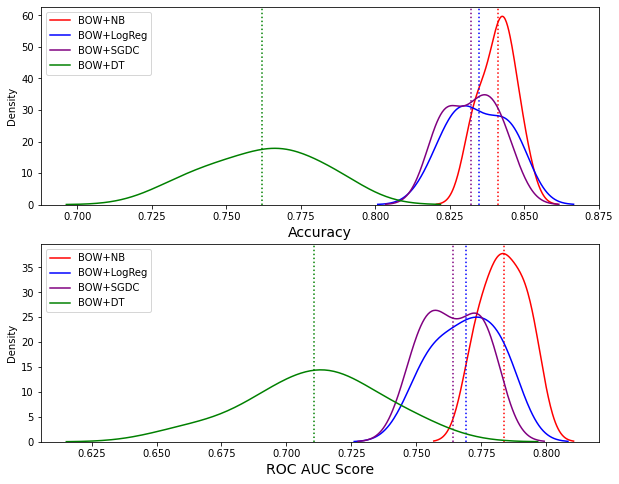

In [ ]:
# List to store all models
models_bow = [bow_nb,bow_logreg,bow_sgdc,bow_dt]
colors = ['red','blue','purple','green','orange']

# Plot histogram of roc accuracy score
fig, (ax1,ax2) = plt.subplots(nrows=2,ncols=1,figsize=(10,8))

# Iterate over all models
for i,model in enumerate(models_bow):
    
    # Plot accuracy
    sns.kdeplot(model.cv_accuracy_score,ax=ax1,color=colors[i],label=model.name)
    ax1.axvline(x=np.mean(model.cv_accuracy_score),color=colors[i],ls=':')
    
    ax1.legend()
    ax1.set_xlabel('Accuracy',fontsize=14)
    
    # Plot ROC AUC score
    sns.kdeplot(model.cv_roc_auc_score,ax=ax2,label=model.name,color=colors[i])
    ax2.axvline(x=np.mean(model.cv_roc_auc_score),color=colors[i],ls=':')
    
    ax2.legend()
    ax2.set_xlabel('ROC AUC Score',fontsize=14)

It looks like our baseline model, i.e. BOW+Naive Bayes performs the best out of the other models. Let's see if we can improve these scores by using another vectorizer: TF-IDF.

# 5. Vectorizer: TF-IDF

We have created our baseline model using the simple bag-of-words vectorizer. Now, we will focus on the models that have the best performance, i.e. naive bayes, logistic regression, and stochastic gradient descent. We will use the TF-IDF vectorizer to see if we can improve their performance.

### a. TF-IDF + Naive Bayes

In [ ]:
# Instantiate the model
tfidf_nb = Model('TF-IDF+NB',data_clean,TfidfVectorizer(),MultinomialNB())

In [ ]:
# Train on training set and evaluate prediction on test set
tfidf_nb.train_and_evaluate_base()

Accuracy score: 78.852%
ROC AUC score: 0.656


### b. TF-IDF + Logistic Regression

In [ ]:
# Instantiate the model
tfidf_logreg = Model('TF-IDF+LogReg',data_clean,TfidfVectorizer(),LogisticRegression())

In [ ]:
# Train on training set and evaluate prediction on test set
tfidf_logreg.train_and_evaluate_base()

Accuracy score: 84.828%
ROC AUC score: 0.787


### c. TF-IDF + Stochastic Gradient Descent

In [ ]:
# Instantiate the model
tfidf_sgdc = Model('TF-IDF+SGDC',data_clean,TfidfVectorizer(),SGDClassifier(loss='log_loss',random_state=42))

In [ ]:
# Train on training set and evaluate prediction on test set
tfidf_sgdc.train_and_evaluate_base()

Accuracy score: 84.441%
ROC AUC score: 0.777


### d. TF-IDF + Decision Tree

In [ ]:
# Instantiate the model
tfidf_dt = Model('TF-IDF+DT',data_clean,TfidfVectorizer(),DecisionTreeClassifier(random_state=42))

In [ ]:
# Train on training set and evaluate prediction on test set
tfidf_dt.train_and_evaluate_base()

Accuracy score: 77.487%
ROC AUC score: 0.725


### e. TF-IDF + LGBM

In [ ]:
# Instantiate the model
tfidf_lgbm = Model('TF-IDF+LGBM',data_clean,TfidfVectorizer(),LGBMClassifier(random_state=42))

In [ ]:
# Train on training set and evaluate prediction on test set
tfidf_lgbm.train_and_evaluate_base()

Accuracy score: 83.904%
ROC AUC score: 0.778


### Compare the models

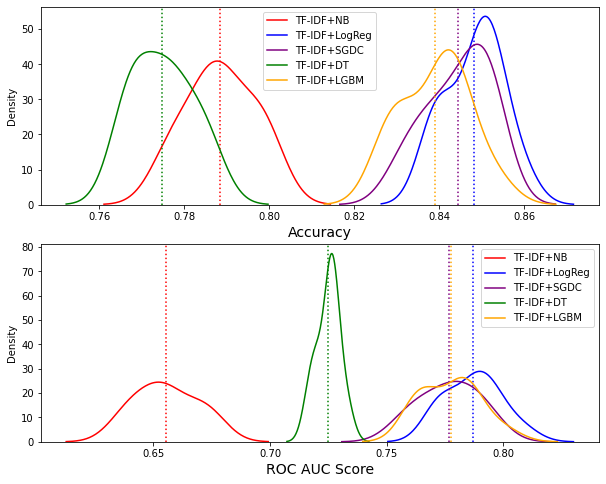

In [ ]:
# List to store all models
models_bow = [tfidf_nb,tfidf_logreg,tfidf_sgdc,tfidf_dt,tfidf_lgbm]

# Plot histogram of roc accuracy score
fig, (ax1,ax2) = plt.subplots(nrows=2,ncols=1,figsize=(10,8))

for i,model in enumerate(models_bow):
    
    # Plot accuracy
    sns.kdeplot(model.cv_accuracy_score,ax=ax1,color=colors[i],label=model.name)
    ax1.axvline(x=np.mean(model.cv_accuracy_score),color=colors[i],ls=':')
    
    ax1.legend()
    ax1.set_xlabel('Accuracy',fontsize=14)
    
    # Plot ROC AUC score
    sns.kdeplot(model.cv_roc_auc_score,ax=ax2,label=model.name,color=colors[i])
    ax2.axvline(x=np.mean(model.cv_roc_auc_score),color=colors[i],ls=':')
    
    ax2.legend()
    ax2.set_xlabel('ROC AUC Score',fontsize=14)

Using TF-IDF as our vectorizer, the best-performing models are the logistic regression, stochastic gradient descent, and LGBM. These models perform better than when bag-of-words vectorizer is used. Another interesting part, the naive bayes performs significantly worse when using TF-IDF.

# 6. Hyperparameter Tuning

We have established our baseline model and using TF-IDF as our text representation. Since our dataset From the results above, the most promising models are logistic regression and stochastic gradient descent. We will focus only on these three models and see if we can still improve the model performance by tuning the hyperparameters and equal sampling of the target classes.

In [ ]:
# Dictionary for Bayesian search
# Vectorizer
param_vec = {
    'vec__ngram_range': hp.choice('ngram_range',[(1,1),(1,2),(1,3)]),
    'vec__max_df': hp.choice('max_df',[0.5,0.75,1.0]),
    'vec__min_df': hp.choice('min_df',[1,5,10]),
    'vec__max_features': hp.choice('max_features',[None, 500, 1000])
}

# Range of hyperparameters for the classifiers
# Classifier: naive bayes
param_nb = {
    'clf__alpha': hp.loguniform('alpha',-3,1)
}

# Classifier: Logistic Regression
param_logreg = {
    'clf__C': hp.loguniform('C',-3,1),
    'clf__penalty': hp.choice('penalty',['l2','none']),
    'clf__solver': hp.choice('solver',['newton-cg','lbfgs'])
}

# Classifier: SGDC
param_sgdc = {
    'clf__alpha': hp.choice('alpha',np.logspace(-5,0,6))
}

# Classifier: Decision Tree
param_dt = {
    'clf__criterion': hp.choice('criterion',['gini','entropy']),
    'clf__max_depth': hp.choice("max_depth_dtree", np.arange(10,50,10)),
    'clf__min_samples_leaf': hp.choice('min_samples_leaf',[5,10,20,50,100])
}

# Classifier: LGBM
param_lgbm = {
    'clf__max_depth': hp.choice('max_depth',np.arange(3,10,1)),
    'clf__num_leaves': hp.choice('num_leaves',np.arange(20,3000)),
    'clf__learning_rate': hp.uniform('learning_rate',0.05,0.2)
}

### a. TF-IDF+Naive Bayes

In [ ]:
# Use bayesian search
tfidf_nb.bayes_search(space={**param_vec,**param_nb})

100%|██████████| 50/50 [03:09<00:00,  3.79s/trial, best loss: 0.15388098374408232]


In [ ]:
# Print the best hyperparameters
tfidf_nb.best_params_hp

{'clf__alpha': 0.05282287714412626,
 'vec__max_df': 0.75,
 'vec__max_features': None,
 'vec__min_df': 5,
 'vec__ngram_range': (1, 3)}

In [ ]:
# Evaluate model with cross-validation using the best hyperparameters
tfidf_nb.train_and_evaluate_hp()

Accuracy score: 84.727%
ROC AUC score: 0.788


### b. TF-IDF + Logistic Regression

In [ ]:
# Use bayesian search
tfidf_logreg.bayes_search(space={**param_vec,**param_logreg})

100%|██████████| 50/50 [08:24<00:00, 10.09s/trial, best loss: 0.14640508144193165]


In [ ]:
# Print the best hyperparameters
tfidf_logreg.best_params_hp

{'clf__C': 2.157987368910842,
 'clf__penalty': 'l2',
 'clf__solver': 'newton-cg',
 'vec__max_df': 0.5,
 'vec__max_features': None,
 'vec__min_df': 1,
 'vec__ngram_range': (1, 2)}

In [ ]:
# Evaluate model with cross-validation using the best hyperparameters
tfidf_logreg.train_and_evaluate_hp()

Accuracy score: 85.465%
ROC AUC score: 0.802


### c. TF-IDF + Stochastic Gradient Descent

In [ ]:
# Use bayesian search
tfidf_sgdc.bayes_search(space={**param_vec,**param_sgdc})

100%|██████████| 50/50 [02:54<00:00,  3.48s/trial, best loss: 0.14906428834001528]


In [ ]:
# Print the best hyperparameters
tfidf_sgdc.best_params_hp

{'clf__alpha': 1e-05,
 'vec__max_df': 0.5,
 'vec__max_features': None,
 'vec__min_df': 5,
 'vec__ngram_range': (1, 3)}

In [ ]:
# Evaluate model with cross-validation using the best hyperparameters
tfidf_sgdc.train_and_evaluate_hp()

Accuracy score: 84.978%
ROC AUC score: 0.803


### d. TF-IDF + Decision Tree

In [ ]:
# Use bayesian search
tfidf_dt.bayes_search(space={**param_vec,**param_dt})

100%|██████████| 50/50 [03:31<00:00,  4.24s/trial, best loss: 0.21002500474761732]


In [ ]:
# Print the best hyperparameters
tfidf_dt.best_params_hp

{'clf__criterion': 'entropy',
 'clf__max_depth': 40,
 'clf__min_samples_leaf': 20,
 'vec__max_df': 1.0,
 'vec__max_features': 500,
 'vec__min_df': 10,
 'vec__ngram_range': (1, 1)}

In [ ]:
# Evaluate model with cross-validation using the best hyperparameters
tfidf_dt.train_and_evaluate_hp()

Accuracy score: 79.168%
ROC AUC score: 0.705


### e. TF-IDF + LGBM

In [ ]:
# Use bayesian search
tfidf_lgbm.bayes_search(space={**param_vec,**param_lgbm})

 14%|█▍        | 7/50 [01:07<06:46,  9.45s/trial, best loss: 0.16742763202686706]

/home/mrafifrbbn/.local/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



 64%|██████▍   | 32/50 [04:55<03:30, 11.68s/trial, best loss: 0.165220055999862]  

/home/mrafifrbbn/.local/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



100%|██████████| 50/50 [08:30<00:00, 10.22s/trial, best loss: 0.16486890220612893]


In [ ]:
# Print the best hyperparameters
tfidf_lgbm.best_params_hp

{'clf__learning_rate': 0.1665656084563607,
 'clf__max_depth': 9,
 'clf__num_leaves': 2706,
 'vec__max_df': 0.75,
 'vec__max_features': None,
 'vec__min_df': 1,
 'vec__ngram_range': (1, 2)}

In [ ]:
# Evaluate model with cross-validation using the best hyperparameters
tfidf_lgbm.train_and_evaluate_hp()

Accuracy score: 83.493%
ROC AUC score: 0.766


### Compare the models

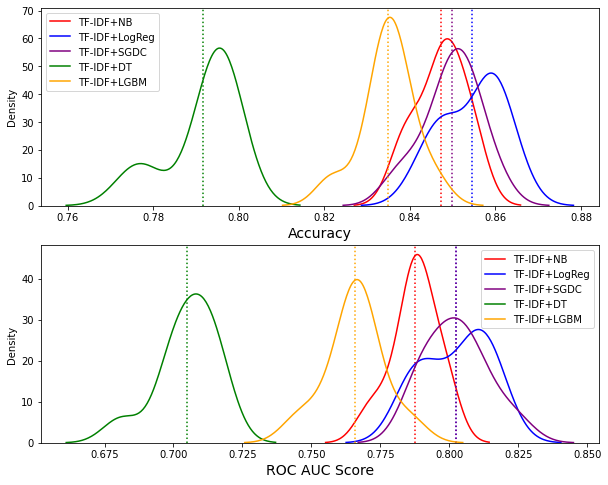

In [ ]:
# List to store all models
models_best = [tfidf_nb,tfidf_logreg,tfidf_sgdc,tfidf_dt,tfidf_lgbm]

# Plot histogram of roc accuracy score
fig, (ax1,ax2) = plt.subplots(nrows=2,ncols=1,figsize=(10,8))

for i,model in enumerate(models_best):
    
    # Plot accuracy
    sns.kdeplot(model.cv_accuracy_score_hp,ax=ax1,color=colors[i],label=model.name)
    ax1.axvline(x=np.mean(model.cv_accuracy_score_hp),color=colors[i],ls=':')
    
    ax1.legend()
    ax1.set_xlabel('Accuracy',fontsize=14)
    
    # Plot ROC AUC score
    sns.kdeplot(model.cv_roc_auc_score_hp,ax=ax2,label=model.name,color=colors[i])
    ax2.axvline(x=np.mean(model.cv_roc_auc_score_hp),color=colors[i],ls=':')
    
    ax2.legend()
    ax2.set_xlabel('ROC AUC Score',fontsize=14)

# 7. Imbalance Handling

We already know in the EDA section that our dataset is imbalanced, where the majority class, `Recommended`, is more than three times as many as the minority class, `Not Recommended`. We will now try to balance the classes and see if we can still improve our model performance. We will only use the undersampling method of the majority class, since ~4000 reviews should be plenty enough to train our model.

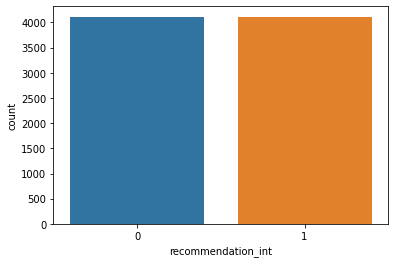

In [ ]:
# Import undersampling
from imblearn.under_sampling import RandomUnderSampler

X = data_train[['review']]
y = data_train[['recommendation_int']]

# Undersampling
X_under, y_under = RandomUnderSampler(random_state=42).fit_resample(X,y)
data_under = X_under.join(y_under)

# Check count plot
sns.countplot(x='recommendation_int',data=data_under)

### a. TF-IDF + Naive Bayes

In [ ]:
# Define the model
tfidf_nb_balanced = Model('TF-IDF+NB',data_under,TfidfVectorizer(),MultinomialNB())

In [ ]:
# Perform bayesian search
tfidf_nb_balanced.bayes_search(space={**param_vec,**param_nb})

100%|██████████| 50/50 [01:09<00:00,  1.40s/trial, best loss: 0.1889131984326008] 


In [ ]:
# Evaluate with cross validation
tfidf_nb_balanced.train_and_evaluate_hp()

Accuracy score: 81.084%
ROC AUC score: 0.811


### b. TF-IDF + Logistic Regression

In [ ]:
# Define the model
tfidf_logreg_balanced = Model('TF-IDF+LogReg',data_under,TfidfVectorizer(),LogisticRegression())

In [ ]:
# Perform bayesian search
tfidf_logreg_balanced.bayes_search(space={**param_vec,**param_logreg})

100%|██████████| 50/50 [02:46<00:00,  3.32s/trial, best loss: 0.1806486019345046] 


In [ ]:
# Evaluate with cross validation
tfidf_logreg_balanced.train_and_evaluate_hp()

Accuracy score: 82.348%
ROC AUC score: 0.823


### c. TF-IDF + Stochastic Gradient Descent

In [ ]:
# Instantiate the model
tfidf_sgdc_balanced = Model('TF-IDF+SGDC',data_under,TfidfVectorizer(),SGDClassifier(loss='log_loss',random_state=42))

In [ ]:
# Perform bayesian search
tfidf_sgdc_balanced.bayes_search(space={**param_vec,**param_sgdc})

100%|██████████| 50/50 [01:18<00:00,  1.56s/trial, best loss: 0.18125650467006693]


In [ ]:
# Evaluate with cross validation
tfidf_sgdc_balanced.train_and_evaluate_hp()

Accuracy score: 82.239%
ROC AUC score: 0.822


### d. TF-IDF + Decision Tree

In [ ]:
# Instantiate the model
tfidf_dt_balanced = Model('TF-IDF+DT',data_under,TfidfVectorizer(),DecisionTreeClassifier(random_state=42))

In [ ]:
# Perform bayesian search
tfidf_dt_balanced.bayes_search(space={**param_vec,**param_dt})

100%|██████████| 50/50 [01:21<00:00,  1.64s/trial, best loss: 0.27486222471719224]


In [ ]:
# Evaluate with cross validation
tfidf_dt_balanced.train_and_evaluate_hp()

Accuracy score: 72.247%
ROC AUC score: 0.722


### e. TF-IDF + LGBM

In [ ]:
# Instantiate the model
tfidf_lgbm_balanced = Model('TF-IDF+LGBM',data_under,TfidfVectorizer(),LGBMClassifier(random_state=42))

In [ ]:
# Perform bayesian search
tfidf_lgbm_balanced.bayes_search(space={**param_vec,**param_lgbm})

100%|██████████| 50/50 [02:54<00:00,  3.48s/trial, best loss: 0.20192202151665462]


In [ ]:
# Evaluate with cross validation
tfidf_lgbm_balanced.train_and_evaluate_hp()

Accuracy score: 79.613%
ROC AUC score: 0.796


### Compare the models

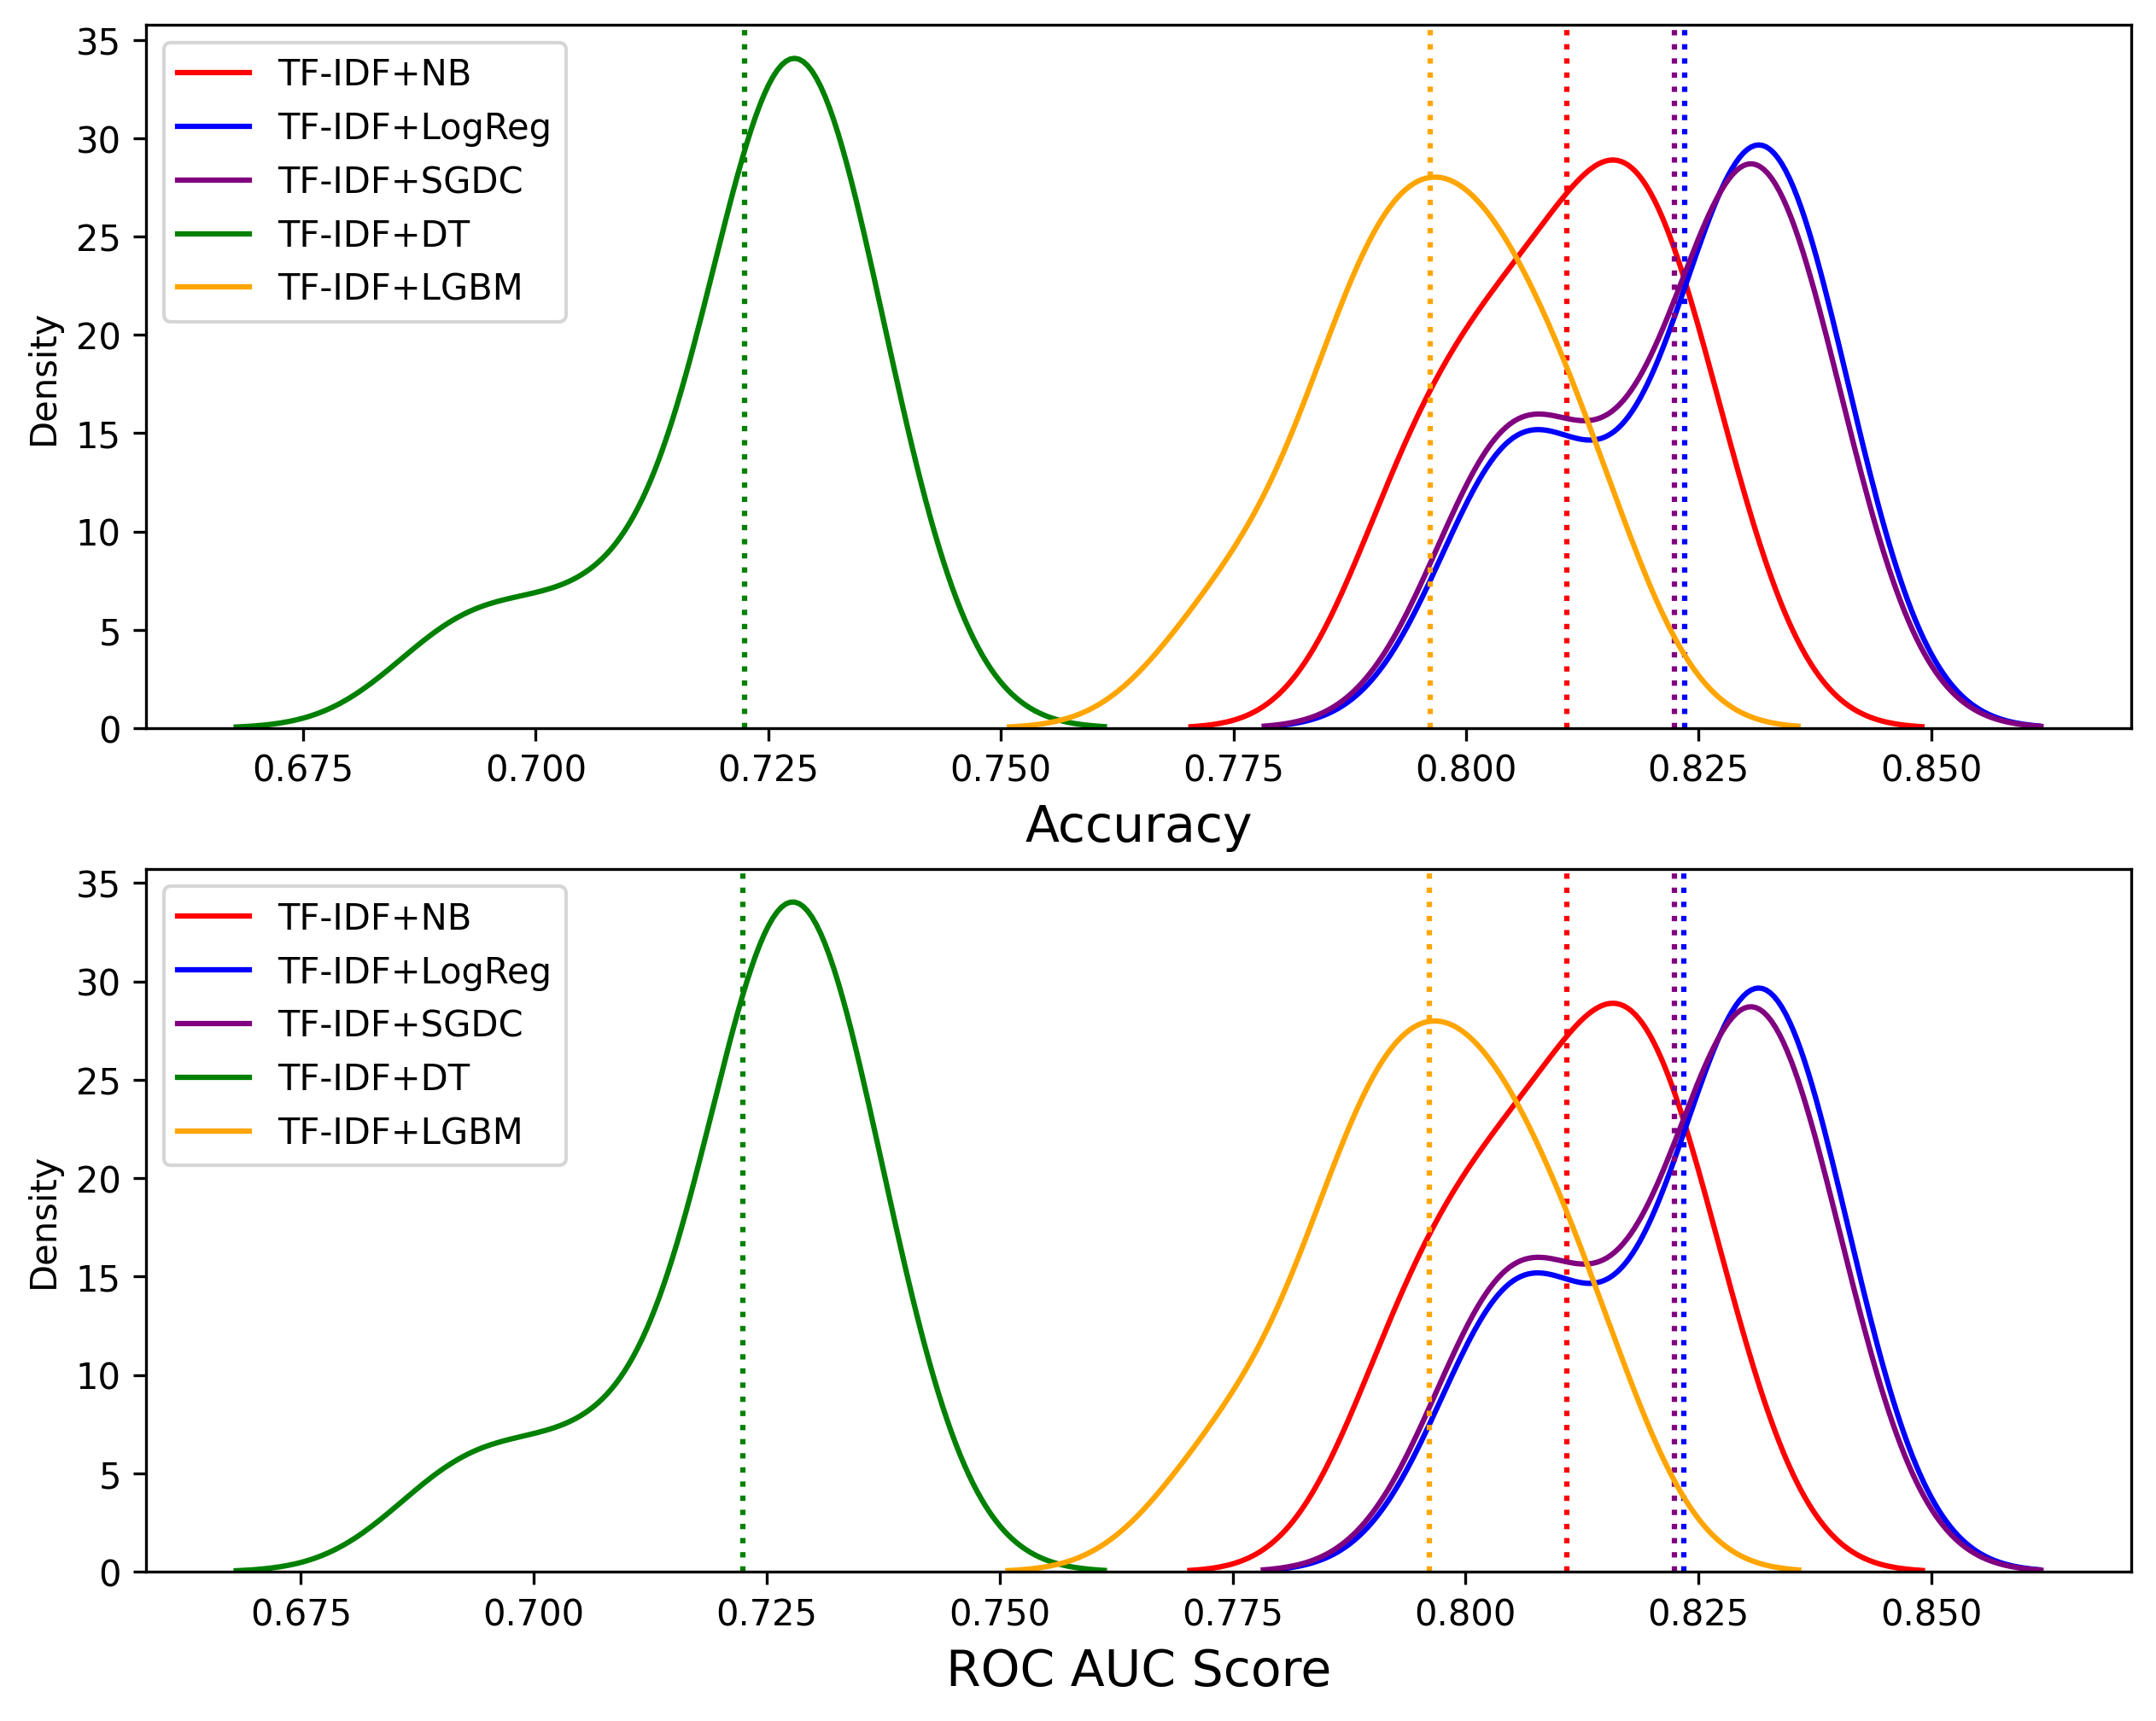

In [ ]:
# List to store all models
models_best = [tfidf_nb_balanced,tfidf_logreg_balanced,tfidf_sgdc_balanced,tfidf_dt_balanced,tfidf_lgbm_balanced]
colors = ['red','blue','purple','green','orange']

# Plot histogram of roc accuracy score
fig, (ax1,ax2) = plt.subplots(nrows=2,ncols=1,figsize=(10,8))

for i,model in enumerate(models_best):
    
    # Plot accuracy
    sns.kdeplot(model.cv_accuracy_score_hp,ax=ax1,color=colors[i],label=model.name)
    ax1.axvline(x=np.mean(model.cv_accuracy_score_hp),color=colors[i],ls=':')
    
    ax1.legend()
    ax1.set_xlabel('Accuracy',fontsize=14)
    
    # Plot ROC AUC score
    sns.kdeplot(model.cv_roc_auc_score_hp,ax=ax2,label=model.name,color=colors[i])
    ax2.axvline(x=np.mean(model.cv_roc_auc_score_hp),color=colors[i],ls=':')
    
    ax2.legend()
    ax2.set_xlabel('ROC AUC Score',fontsize=14)

It looks like training our model on a balanced dataset does not improve the performance significantly. However, one advantage of balancing the dataset is that the accuracy score can now be interpreted more objectively. Based on the average score from cross-validation, the best-performing model is the TF-IDF+LogReg, which is consistent with the results obtained from the original training set, followed by TF-IDF+SGDC and TF-IDF+NB. 

Therefore, we will choose TF-IDF+LogReg with the obtained hyperparameters as our best and final model, and use it to make predictions on the test data.

# 7. Model Evaluation

In [ ]:
# Make predictions on test data using baseline model
baseline_model.predict_test(data_test,False)

Model: BOW+NB 

Confusion matrix: 
 [[1181  632]
 [ 347 3820]] 

Classification report: 
               precision    recall  f1-score   support

           0       0.77      0.65      0.71      1813
           1       0.86      0.92      0.89      4167

    accuracy                           0.84      5980
   macro avg       0.82      0.78      0.80      5980
weighted avg       0.83      0.84      0.83      5980



TN - True Positive: 3820
FP - False Negative: 347
FN - False Positive: 632
TP - True Negative: 1181
Accuracy Rate: 83.6%
Misclassification Rate: 16.400000000000002%
Recall: 0.917
Precision: 0.858
F1-Score: 0.886
ROC-AUC score: 0.784


In [ ]:
# Predictions on test data using our best model
tfidf_logreg.predict_test(data_test,True)

Model: TF-IDF+LogReg 

Confusion matrix: 
 [[1537  276]
 [  69 4098]] 

Classification report: 
               precision    recall  f1-score   support

           0       0.96      0.85      0.90      1813
           1       0.94      0.98      0.96      4167

    accuracy                           0.94      5980
   macro avg       0.95      0.92      0.93      5980
weighted avg       0.94      0.94      0.94      5980



TN - True Positive: 4098
FP - False Negative: 69
FN - False Positive: 276
TP - True Negative: 1537
Accuracy Rate: 94.19999999999999%
Misclassification Rate: 5.800000000000001%
Recall: 0.983
Precision: 0.937
F1-Score: 0.96
ROC-AUC score: 0.916


Whoa, it looks like our best model performs much better on the test set than during the cross-validation with the training data! This number seems too good to be true though, so it's a good idea to be skeptical about this result and test this same model on larger dataset from different sources.

Let's see what words are strongly associated with good reviews, and words that are associated with bad reviews.

### Check features

In [ ]:
# Use eli5
import eli5

eli5.show_weights(tfidf_logreg.final_pipeline, vec=tfidf_logreg.final_pipeline.named_steps["vec"], top=20)

/home/mrafifrbbn/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Words with positive weights are 'great', 'best', 'amazing', etc. They seem to be mostly compliments to the games, and they are not that useful as feedback for game developers. However, some of the negative words are 'mod', 'crash', 'cheater', 'hacker', and 'lag'. Among the top games in this dataset are PUBG and Rust, which are both FPS games. And as someone who plays FPS game, these problems are also commonly found in other FPS games I have played, which made my gaming experience not pleasant. So it looks like our model has captured the most important problems from the opinions of the reviewers.

Let's plot the ROC and precision-recall curve to see how our model has improved the baseline model.

### Plot ROC curve

In [ ]:
# Function to plot ROC curve
def plot_roc(models,colors,labels):
    # Define figure object
    plt.figure(figsize=(6,6))
    
    for i, model in enumerate(models):
        model.get_roc(color=colors[i],label=labels[i])

    # Extra touch
    plt.plot([0.,1.],[0.,1.],color='k',ls='--',label='random classifier')
    plt.xlabel('False Positive Rate',fontsize=14)
    plt.ylabel('True Positive Rate',fontsize=14)
    plt.title('ROC curve',fontsize=14)
    plt.xlim(0.,1.)
    plt.ylim(0.,1.)
    plt.legend(loc='lower right')
    plt.show()
    return

# Function to plot precision-recall curve
def plot_prc(models,colors,labels):
    # Define figure object
    plt.figure(figsize=(6,6))
    
    for i, model in enumerate(models):
        model.get_prc(color=colors[i],label=labels[i])

    # Extra touch
    plt.axhline(y=models[0].y_noskill,color='k',ls='--',label='random classifier')
    plt.xlabel('Recall',fontsize=14)
    plt.ylabel('Precision',fontsize=14)
    plt.title('Precision-recall curve',fontsize=14)
    plt.xlim(0.,1.)
    plt.legend(loc='center left')
    plt.show()
    return

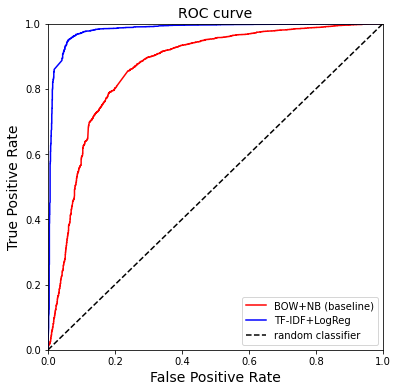

In [ ]:
models_best = [baseline_model,tfidf_logreg]
colors = ['red','blue']
labels = ['BOW+NB (baseline)','TF-IDF+LogReg']

plot_roc(models_best,colors,labels)

### Plot precision-recall curve

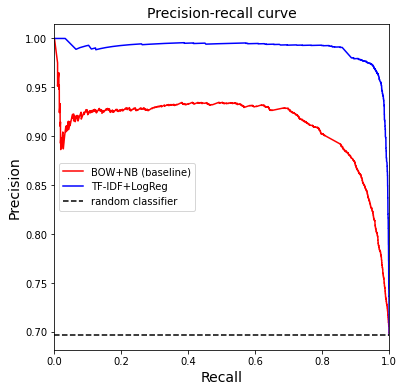

In [ ]:
plot_prc(models_best,colors,labels)

# Conclusions:

1. We have analyzed a subset of the Steam Games Reviews dataset from Kaggle.
2. Most of the reviews are positive, with frequent words such as 'awesome', 'fun', and 'love'. While the negative reviews are filled with words such as 'cheater', 'bug', and 'hacker'.
3. We have applied standard text cleaning to clean the reviews: removing punctuations, digits, stop words, and stemming.
4. We set our baseline model as BOW + Naive Bayes, as it is commonly used in text classification such as spam detection. After trying out models using TF-IDF as the vectorizer and employing hyperparameter tuning using the Bayesian search, our best model is the TF-IDF+logistic regression (TF-IDF+LogReg).
5. From the cross-validation method using the test data, the TF-IDF+LogReg model yields an accuracy of 84.603% and an ROC AUC score of 0.779. These numbers increased to 85.465% for accuracy and 0.802 for ROC AUC.
6. We find that training the model on a balanced training set using undersampling method does not improve the performance significantly.
7. The baseline model, which we take to be BOW+NB, yields an accuracy of 83.6% and an ROC AUC score of 0.784 on the test data. Whereas the TF-IDF+LogReg yields an accuracy of 94.2% and an ROC AUC score of 0.916 on the test data, and so we have built a model with a much better performance than our baseline model. This accuracy seems to be too high, and so it may be better to immediately test it on a new, unseen dataset from a different source.